# Remote LLM Inference: Running Modern Models on Google Colab

* * *

<div class="alert alert-success">  
    
### Learning Objectives
    
* Run modern language models on Google Colab
* Understand practical limits of remote inference
* Implement efficient processing for research tasks
</div>

**PLEASE MAKE SURE TO OPEN THIS NOTEBOOK IN GOOGLE COLAB: [colab.research.google.com](colab.research.google.com)**

### Models
*Updated 11/09/2025*

| Model | Size | RAM Needed | Notable Features |
|-------|------|------------|-----------------|
| Qwen3Guard-Gen-0.6B | 0.6B | 2GB | Latest safety-focused model, 119 languages |
| TinyLlama-1.1B | 1.1B | 3GB | Fastest, good for basic tasks |
| Qwen3-4B | 4B | 7GB | Latest Alibaba model, thinking/non-thinking modes |
| Phi-2 | 2.7B | 6GB | Microsoft, excellent reasoning |
| Yi-6B | 6B | 8GB | Strong bilingual, excellent for code |
| Neural-Chat-7B-v3-1 | 7B | 9GB | Optimized for chat, Intel |
| Qwen2.5-7B | 7B | 9GB | Stable Qwen model, strong general performance |
| GPT-OSS-20B | 20B | 16GB | Strong general performance |

All models are open-weights and available on Hugging Face. Models are listed from smallest to largest, with specialized models noted for their strengths. The 0.6B-4B models are particularly suitable for local inference on laptops.

### Sections
1. [Hardware Detection](#setup)
2. [Simple Installation](#install)
3. [Loading Models](#load)
4. [Text Generation](#generation)
5. [Practical Examples](#examples)
6. [Performance Tips](#performance)

<a id='setup'></a>

# Google Colab GPU Setup

**Colab GPU Tiers and Compatible Models:**

- **T4 GPU (Free Tier - 16GB)**: Qwen2.5-7B, Llama-3.2-3B, Phi-3.5-mini
- **L4 GPU (Colab Pro - 24GB)**: Qwen2.5-14B, Mistral-Nemo-12B
- **A100 GPU (Colab Pro+ - 40GB)**: Qwen2.5-32B, Mistral Small 3

## Enable and Auto-Detect GPU

**Step 1: Enable GPU Runtime**
1. Go to `Runtime` → `Change runtime type`
2. Set `Hardware accelerator` to `T4 GPU` (or L4/A100 if you have Pro/Pro+)
3. Switch on 'High-RAM' mode which allocates more memory.
4. Click `Save` (this will restart your runtime)

In [ ]:
# Check Colab system resources
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

# Check RAM
!free -h

# Check disk space
!df -h /content

Tesla T4, 15360 MiB, 15095 MiB
               total        used        free      shared  buff/cache   available
Mem:            50Gi       779Mi        46Gi       1.0Mi       3.5Gi        49Gi
Swap:             0B          0B          0B
Filesystem      Size  Used Avail Use% Mounted on
overlay         236G   39G  198G  17% /


<a id='install'></a>

# Installation

In [ ]:
# Install only essential packages
!pip install -q torch transformers accelerate
!pip install -q psutil  # For system monitoring

# Verify versions
import transformers
import torch
print(f"\nTransformers version: {transformers.__version__}")
print(f"PyTorch version: {torch.__version__}")


Transformers version: 4.57.1
PyTorch version: 2.8.0+cu126


<a id='load'></a>

# Loading Models

Load a model. We'll use standard transformers library - simple and reliable!

An “Instruct model” (short for instruction-tuned model) is a large language model that has been fine-tuned to follow human instructions in natural language.

It starts from a base model (which just predicts the next token in raw text), and then goes through an extra supervised fintuning phase (*instruction tuning*) where the model learns to interpret instructions (“summarize”, “explain”, “compare”), and to respond in helpful, complete sentences.

In [ ]:
import platform
import psutil
import torch

def detect_hardware():
    # Operating System
    system = platform.system()
    print(f"OS: {system} {platform.release()}")
    print(f"Python: {platform.python_version()}")

    # CPU
    print(f"\nCPU: {platform.processor()}")
    print(f"Cores: {psutil.cpu_count(logical=False)} physical, {psutil.cpu_count()} logical")

    # Memory
    ram = psutil.virtual_memory().total / (1024**3)
    available_ram = psutil.virtual_memory().available / (1024**3)
    print(f"\nRAM: {ram:.1f} GB total")
    print(f"Available: {available_ram:.1f} GB")

    # Check for acceleration
    print("\nAcceleration:")

    # Apple Silicon (MPS)
    if torch.backends.mps.is_available():
        print("Apple Silicon detected (MPS acceleration available)")
        device = "mps"
    # NVIDIA GPU
    elif torch.cuda.is_available():
        print(f"NVIDIA GPU detected: {torch.cuda.get_device_name(0)}")
        device = "cuda"
    # CPU only
    else:
        print("ℹUsing CPU (no GPU acceleration detected)")
        device = "cpu"

    return device

# Detect hardware
DEVICE = detect_hardware()


OS: Linux 6.6.105+
Python: 3.12.12

CPU: x86_64
Cores: 4 physical, 8 logical

RAM: 51.0 GB total
Available: 49.2 GB

Acceleration:
NVIDIA GPU detected: Tesla T4


In [ ]:
DEVICE

'cuda'

We will use `Qwen2.5-1.5B-Instruct`, a lightweight 1.5-billion-parameter instruction-tuned language model from Alibaba’s Qwen 2.5 family, optimized for fast, efficient reasoning and chat on limited hardware like Google Colab GPUs or laptops.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

MODEL_NAME = "Qwen/Qwen2.5-1.5B-Instruct"

# Alternative models by RAM requirement:
# 2-3GB RAM:  "Qwen/Qwen3Guard-Gen-0.6B" (0.6B) - Efficient safety classifier / guardrail model
# 3-4GB RAM:  "TinyLlama-1.1B" (1.1B) - Fast, good for basic tasks
# 6-7GB RAM:  "microsoft/phi-2" (2.7B) - Strong reasoning
# 7-8GB RAM:  "Qwen/Qwen3-4B" (4B) - Latest Qwen, thinking mode
# 8-9GB RAM:  "01-ai/Yi-6B" (6B) - Excellent for code
# 9-10GB RAM: "Qwen/Qwen2.5-7B" (7B) - Stable performance

print(f"Loading {MODEL_NAME}...")

try:
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

    # Load model with appropriate settings
    if DEVICE == "mps":  # Apple Silicon
        model = AutoModelForCausalLM.from_pretrained(
            MODEL_NAME,
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True,
            trust_remote_code=True
        ).to(DEVICE)
    elif DEVICE == "cuda":  # NVIDIA GPU
        model = AutoModelForCausalLM.from_pretrained(
            MODEL_NAME,
            torch_dtype=torch.float16,
            device_map="auto",
            trust_remote_code=True
        )
    else:  # CPU
        model = AutoModelForCausalLM.from_pretrained(
            MODEL_NAME,
            torch_dtype=torch.float32,  # Full precision for CPU
            low_cpu_mem_usage=True,
            trust_remote_code=True
        )

    # Set pad token if needed
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    print(f"✅ Model loaded successfully!")
    print(f"   Device: {DEVICE}")
    print(f"   Model size: ~{sum(p.numel() for p in model.parameters())/1e9:.1f}B parameters")

except Exception as e:
    print(f"❌ Error loading model: {e}")

Loading Qwen/Qwen2.5-1.5B-Instruct...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

✅ Model loaded successfully!
   Device: cuda
   Model size: ~1.5B parameters


<a id='generation'></a>

# Text Generation

In this section, we'll define a helper function to generate text.

This process is called **inference** — it’s when we give the model an input prompt and let it predict the next words, one token at a time.

The function we’ll create will handle three main tasks:

1. **Formatting the input** — turning a text prompt into tokens the model understands.  
2. **Generating new tokens** — asking the model to produce text based on the prompt.  
3. **Decoding the output** — converting tokens back into readable text.

In [ ]:
from google.colab import files
print("Select your first CSV file:")
uploaded1 = files.upload()
print("\nSelect your second CSV file:")
uploaded2 = files.upload()

# Get the filenames
file1_name = list(uploaded1.keys())[0]
file2_name = list(uploaded2.keys())[0]

print(f"File 1: {file1_name}")
print(f"File 2: {file2_name}")

Select your first CSV file:


Saving df_dropped_rows_w_statepartyna.csv to df_dropped_rows_w_statepartyna.csv

Select your second CSV file:


Saving df_dropped_rows.csv to df_dropped_rows.csv
File 1: df_dropped_rows_w_statepartyna.csv
File 2: df_dropped_rows.csv


In [ ]:
import pandas as pd

# Load both files
df1 = pd.read_csv('df_dropped_rows_w_statepartyna.csv')
df2 = pd.read_csv('df_dropped_rows.csv')

# Check what you have
print("DF1 Info:")
print(f"  Shape: {df1.shape}")
print(f"  Columns: {df1.columns.tolist()}")
print(f"\nDF2 Info:")
print(f"  Shape: {df2.shape}")
print(f"  Columns: {df2.columns.tolist()}")

DF1 Info:
  Shape: (26639, 9)
  Columns: ['Chamber', 'Year', 'Speaker', 'Party', 'State', 'Title', 'speech_text', 'turn_number', 'speech_length_words']

DF2 Info:
  Shape: (23317, 9)
  Columns: ['Chamber', 'Year', 'Speaker', 'Party', 'State', 'Title', 'speech_text', 'turn_number', 'speech_length_words']


In [ ]:
# Combine both dataframes
df_combined = pd.concat([df1, df2], ignore_index=True)

# Check the result
print(f"DF1 rows: {len(df1)}")
print(f"DF2 rows: {len(df2)}")
print(f"Combined rows: {len(df_combined)}")
print(f"\nCombined shape: {df_combined.shape}")
print(f"\nYear range: {df_combined['Year'].min()} - {df_combined['Year'].max()}")
print(f"Parties: {df_combined['Party'].unique()}")
print(f"Chambers: {df_combined['Chamber'].unique()}")
print(f"\nSample speech:")
print(df_combined['speech_text'].iloc[0][:200])

DF1 rows: 26639
DF2 rows: 23317
Combined rows: 49956

Combined shape: (49956, 9)

Year range: 1995 - 2025
Parties: ['Republican' 'Democrat' nan 'Independent']
Chambers: ['House' 'Senate']

Sample speech:
Mr. Speaker, I move to suspend the rules and pass the bill (H.R. 965) to amend section 3(b)(4) of the United States Housing Act of 1937 to exclude certain disability benefits from income for the purpo


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Check GPU availability
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
import torch
import gc

# Clear GPU memory
torch.cuda.empty_cache()
gc.collect()

# Check available memory
print(torch.cuda.get_device_properties(0))
print(f"GPU memory available: {torch.cuda.mem_get_info()[0] / 1e9:.2f} GB")

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15095MB, multi_processor_count=40, uuid=ef15b71a-3511-5914-c0ac-5af4373b83ca, pci_bus_id=0, pci_device_id=4, pci_domain_id=0, L2_cache_size=4MB)
GPU memory available: 0.07 GB


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "mistralai/Mistral-7B-Instruct-v0.2"
print("Loading model...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(DEVICE)
print("✓ Model loaded successfully!")

Loading model...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 112.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 68.12 MiB is free. Process 7208 has 14.67 GiB memory in use. Of the allocated memory 14.39 GiB is allocated by PyTorch, and 177.18 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

# Use DistilGPT-2 - very lightweight and perfect for Colab
model_name = "distilgpt2"
print("Loading model...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(DEVICE)
print("✓ Model loaded successfully!")

Loading model...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 148.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 68.12 MiB is free. Process 7208 has 14.67 GiB memory in use. Of the allocated memory 14.39 GiB is allocated by PyTorch, and 177.18 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Option A: DistilGPT-2 (smallest, fastest)
model_name = "distilgpt2"

# Option B: GPT-2 (small, good quality)
model_name = "gpt2"

# Option C: TinyLlama (slightly larger but better quality)
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

In [ ]:
model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(DEVICE)
print("✓ Model loaded successfully!")

✓ Model loaded successfully!


In [ ]:
def generate_congressional_speech(
    data_df=df_combined,
    topic="homelessness",
    party=None,
    chamber="House",
    max_new_tokens=150,
    temperature=0.7,
):
    """Generate a Congressional speech based on combined Congressional data."""

    # Sample from combined data to match style
    if party:
        examples = data_df[data_df['Party'] == party]['speech_text'].sample(min(3, len(data_df[data_df['Party'] == party])))
    else:
        examples = data_df['speech_text'].sample(min(3, len(data_df)))

    style_examples = "\n".join(examples.values)

    # Fix: Use clearer string formatting
    party_label = party if party else 'bipartisan'
    system_prompt = f"You are a {party_label} member of the US {chamber} speaking about {topic}."

    prompt = f"Based on these Congressional speech examples:\n{style_examples[:500]}...\n\nNow write a speech about {topic}:"

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt},
    ]

    formatted = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(formatted, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=temperature > 0,
            top_p=0.7,
            repetition_penalty=1.1,
            pad_token_id=tokenizer.pad_token_id,
        )

    new_tokens = output[0][inputs["input_ids"].shape[-1]:]
    response = tokenizer.decode(new_tokens, skip_special_tokens=True).strip()

    return response

In [ ]:
def generate_congressional_speech(
    data_df=df_combined,
    topic="homelessness",
    party=None,
    chamber="House",
    max_new_tokens=150,
    temperature=0.7,
):
    """Generate a Congressional speech based on combined Congressional data."""

    # Sample from combined data to match style
    if party:
        examples = data_df[data_df['Party'] == party]['speech_text'].sample(min(3, len(data_df[data_df['Party'] == party])))
    else:
        examples = data_df['speech_text'].sample(min(3, len(data_df)))

    style_examples = "\n".join(examples.values)

    # Create prompt directly (no chat template)
    party_label = party if party else 'bipartisan'
    prompt = f"You are a {party_label} member of the US {chamber} speaking about {topic}.\n\nBased on these Congressional speech examples:\n{style_examples[:300]}...\n\nNow write a speech about {topic}:"

    # Tokenize and generate
    inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=temperature > 0,
            top_p=0.7,
            repetition_penalty=1.1,
            pad_token_id=tokenizer.pad_token_id,
        )

    # Decode only the newly generated tokens
    new_tokens = output[0][inputs["input_ids"].shape[-1]:]
    response = tokenizer.decode(new_tokens, skip_special_tokens=True).strip()

    return response

In [ ]:
speech = generate_congressional_speech(party="Democrat", topic="homelessness")
print(speech)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


This isn't an issue for us at all. We have to stop fighting wars with our friends in Iraq or Afghanistan who want to help them fight against terrorism by building bridges between ourselves and other nations. This doesn’t mean you can build walls around your country but instead make sure they don´t take advantage of those people's resources when needed. That means protecting yourself more than ever before. If there was one thing President Obama had said he would do differently if his administration tried to ban marijuana use across the board – which should happen now? He has done so many things today since taking office. And yet this time Mr. President Trump did what most Americans think him could.


In [ ]:
from collections import Counter
import re

# Comprehensive stop words list
stop_words = {
    "agency", "the", "a", "an", "and", "or", "if", "of", "for", "in", "on", "at", "by", "to", "from", "with",
    "people", "state", "want", "going", "is", "are", "was", "were", "be", "been", "being", "as", "it", "its",
    "this", "that", "these", "those", "i", "me", "my", "we", "our", "you", "your", "he", "she", "they", "them",
    "their", "his", "her", "not", "but", "do", "does", "did", "so", "because", "can", "could", "should", "would",
    "will", "may", "might", "also", "just", "very", "much", "more", "such", "than", "then", "there", "here",
    "when", "where", "who", "what", "which", "how", "all", "any", "each", "every", "some", "no", "nor", "only",
    "own", "same", "too", "into", "up", "down", "about", "over", "under", "thank", "thankyou", "yield", "gentleman",
    "gentlewoman", "chair", "chairman", "chairwoman", "speaker", "presiding", "recognize", "recognized", "recognition",
    "remarks", "floor", "colleague", "colleagues", "proceed", "order", "ordered", "committee", "subcommittee", "motion",
    "unanimous", "consent", "debate", "amendment", "amend", "section", "title", "chapter", "paragraph", "subparagraph",
    "clause", "statutory", "herein", "whereas", "therefore", "resolved", "pursuant", "enact", "enacted", "mr", "mrs",
    "ms", "madam", "sir", "act", "bill", "resolution", "senate", "house", "representative", "representatives", "congress",
    "member", "members", "session", "hearing", "witness", "testimony", "law", "legislation", "legislative", "vote",
    "enactment", "proceedings", "statute", "appropriation", "federal", "agency", "program", "department", "secretary",
    "policy", "administration", "executive", "authority", "director", "office", "ranking", "majority", "minority", "sec",
    "subsec", "subtitle", "appendix", "figure", "table", "page", "pages", "line", "lines", "insert", "strike", "sentence",
    "word", "words", "heading", "part", "division", "codified", "usc", "code", "public", "law", "number", "numbers",
    "date", "dates", "document", "doc", "clerk", "shall", "must", "make", "made", "makes", "take", "taken", "took", "get",
    "got", "getting", "give", "gave", "let", "say", "said", "says", "see", "seen", "look", "looked", "know", "known",
    "think", "thought", "myself", "ours", "ourselves", "your", "yours", "yourself", "yourselves", "him", "his", "himself",
    "hers", "herself", "theirs", "themselves", "itself", "one", "ones", "someone", "anyone", "everyone", "noone", "many",
    "none", "both", "either", "neither", "while", "though", "although", "however", "through", "across", "around", "between",
    "within", "without", "now", "today", "time", "times", "year", "years", "day", "days", "long", "short", "new", "old",
    "first", "second", "third", "next", "last", "us", "including", "need", "percent", "miss", "dr", "chairperson",
    "president", "gentlelady", "gentlemen", "lady", "panel", "rules", "rule", "laws", "policies", "reading", "read",
    "united", "states", "america", "american", "washington", "dc", "bureau", "tomorrow", "week", "body", "move",
    "congressional", "record", "vol", "have", "has", "having", "provide", "provided", "providing", "current", "currently",
    "prior", "previous", "furthermore", "moreover", "thus", "hence", "other","after", "before"
, "striking","like", "following"}

def get_top_words(text_series, n=30, min_length=4):
    """Extract most common meaningful words."""
    all_text = ' '.join(text_series).lower()
    words = re.findall(r'\b[a-z]{' + str(min_length) + r',}\b', all_text)
    words = [w for w in words if w not in stop_words]
    return Counter(words).most_common(n)

# Filter out NaN parties
df_parties = df_combined[df_combined['Party'].notna()].copy()

dem_speeches = df_parties[df_parties['Party'] == 'Democrat']['speech_text']
rep_speeches = df_parties[df_parties['Party'] == 'Republican']['speech_text']

print("=" * 70)
print("TOP MEANINGFUL WORDS - DEMOCRATS (30 most common):")
print("=" * 70)
for word, count in get_top_words(dem_speeches, 30):
    print(f"  {word:20} {count:6}")

print("\n" + "=" * 70)
print("TOP MEANINGFUL WORDS - REPUBLICANS (30 most common):")
print("=" * 70)
for word, count in get_top_words(rep_speeches, 30):
    print(f"  {word:20} {count:6}")

TOP MEANINGFUL WORDS - DEMOCRATS (30 most common):
  health                27676
  support               25004
  veterans              23290
  care                  20104
  children              19732
  housing               19718
  national              18888
  work                  18662
  services              17838
  funds                 17548
  programs              17402
  senator               16310
  assistance            15200
  funding               15170
  million               15138
  country               15012
  available             14920
  families              14340
  report                13620
  education             13564
  subsection            13508
  budget                13224
  defense               12792
  government            12504
  help                  12276
  important             12248
  billion               12192
  service               12008
  general               11610
  security              11132

TOP MEANINGFUL WORDS - REPUBLICANS (30 most comm

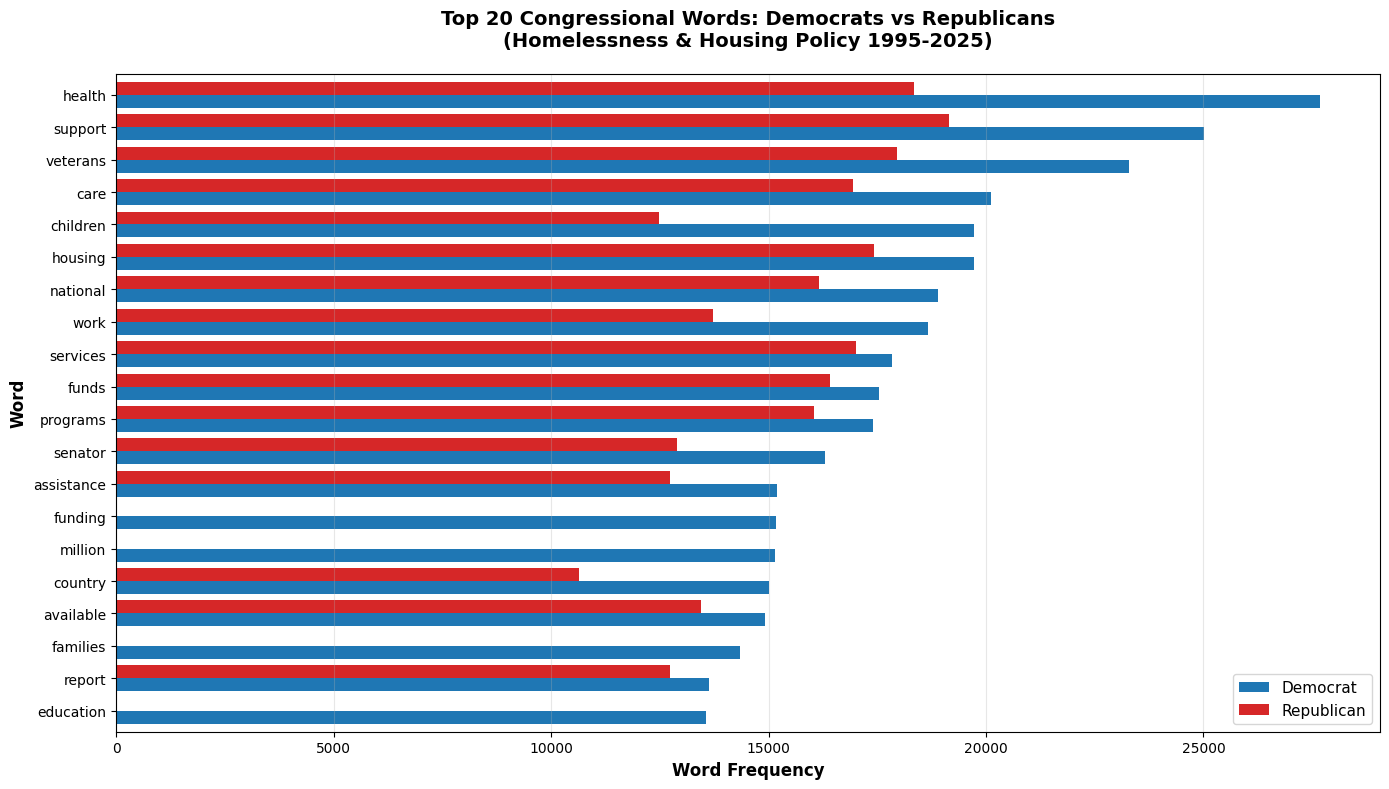


WORDS MORE COMMON IN DEMOCRATIC SPEECHES:
  funding               15170
  million               15138
  families              14340
  education             13564
  help                  12276

WORDS MORE COMMON IN REPUBLICAN SPEECHES:
  fiscal                13540
  general               12926
  amended               12286
  amount                11898
  inserting             11418


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Get top words for both parties
dem_top = dict(get_top_words(dem_speeches, 25))
rep_top = dict(get_top_words(rep_speeches, 25))

# Create comparison dataframe
all_words = sorted(list(set(dem_top.keys()) | set(rep_top.keys())))
comparison_df = pd.DataFrame({
    'Democrat': [dem_top.get(w, 0) for w in all_words],
    'Republican': [rep_top.get(w, 0) for w in all_words]
}, index=all_words)

# Sort by Democrat count and get top 20
comparison_df = comparison_df.sort_values('Democrat', ascending=True).tail(20)

# Create side-by-side bar chart
fig, ax = plt.subplots(figsize=(14, 8))
comparison_df.plot(kind='barh', ax=ax, color=['#1f77b4', '#d62728'], width=0.8)

plt.xlabel('Word Frequency', fontsize=12, fontweight='bold')
plt.ylabel('Word', fontsize=12, fontweight='bold')
plt.title('Top 20 Congressional Words: Democrats vs Republicans\n(Homelessness & Housing Policy 1995-2025)',
          fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=11, loc='lower right')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Also show words unique to each party
dem_only = set(dem_top.keys()) - set(rep_top.keys())
rep_only = set(rep_top.keys()) - set(dem_top.keys())

print("\n" + "="*70)
print("WORDS MORE COMMON IN DEMOCRATIC SPEECHES:")
print("="*70)
dem_unique = [(w, dem_top[w]) for w in dem_only]
dem_unique.sort(key=lambda x: x[1], reverse=True)
for word, count in dem_unique[:15]:
    print(f"  {word:20} {count:6}")

print("\n" + "="*70)
print("WORDS MORE COMMON IN REPUBLICAN SPEECHES:")
print("="*70)
rep_unique = [(w, rep_top[w]) for w in rep_only]
rep_unique.sort(key=lambda x: x[1], reverse=True)
for word, count in rep_unique[:15]:
    print(f"  {word:20} {count:6}")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


SENTIMENT ANALYSIS - DEMOCRATS vs REPUBLICANS

DEMOCRATS (n=23798):
  Mean sentiment:    0.4368
  Median sentiment:  0.8036
  Std deviation:     0.6769
  Min:               -1.0000
  Max:               1.0000

REPUBLICANS (n=22674):
  Mean sentiment:    0.4401
  Median sentiment:  0.7668
  Std deviation:     0.6477
  Min:               -1.0000
  Max:               1.0000


/tmp/ipython-input-1879483923.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(box_data, labels=['Democrats', 'Republicans'], patch_artist=True)


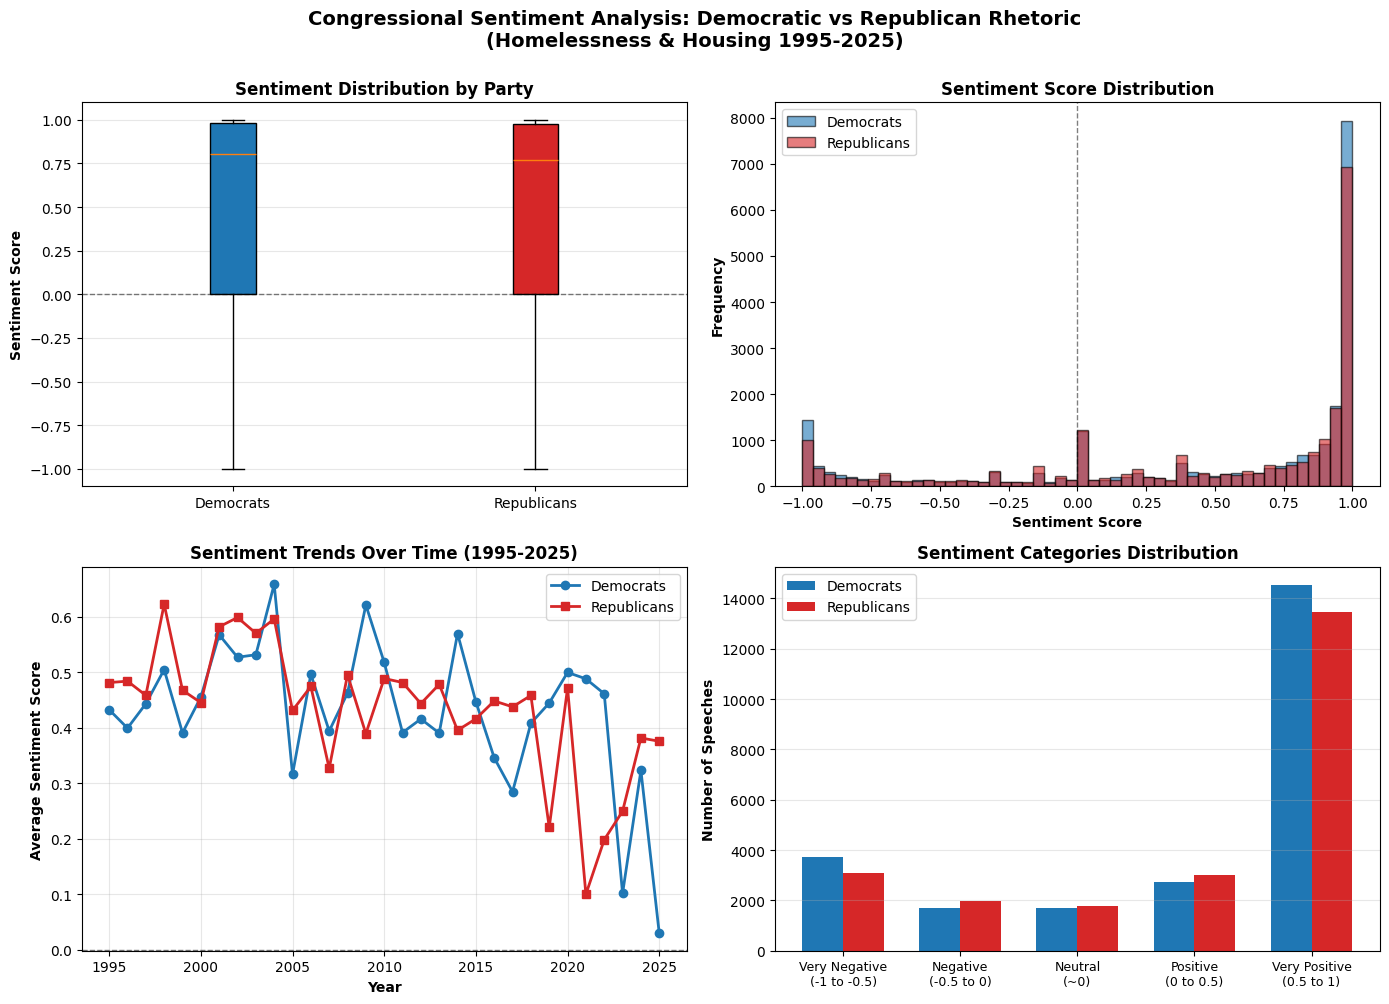


MOST POSITIVE SPEECHES

Democrat - 2020 (Waters): Sentiment = 1.0000
  Mr. Speaker, pursuant to House Resolution 1017, I call up the bill (H.R. 7301) to prevent evictions, foreclosures, and unsafe housing conditions resul...

Democrat - 2009 (Frank): Sentiment = 1.0000
  Mr. Speaker, I move to suspend the rules and pass the Senate bill (S. 896) to prevent mortgage foreclosures and enhance mortgage credit availability, ...

Republican - 2016 (Luetkemeyer): Sentiment = 1.0000
  Mr. Chair, Congressman Capuano has asked whether it is the intention of the bill's managers that the commitment of project- based vouchers to replace ...

MOST NEGATIVE SPEECHES

Democrat - 2010 (Sablan): Sentiment = -1.0000
  Mr. Speaker, I move to suspend the rules and pass the Senate bill (S. 3817) to amend the Child Abuse Prevention and Treatment Act, the Family Violence...

Republican - 2005 (Sensenbrenner): Sentiment = -1.0000
  Mr. Speaker, I move to suspend the rules and concur in the Senate amendment to 

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download VADER sentiment lexicon
nltk.download('vader_lexicon')

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Analyze sentiment for each speech
df_parties['sentiment_score'] = df_parties['speech_text'].apply(
    lambda x: sia.polarity_scores(x)['compound']
)

# Separate by party
dem_sentiment = df_parties[df_parties['Party'] == 'Democrat']['sentiment_score']
rep_sentiment = df_parties[df_parties['Party'] == 'Republican']['sentiment_score']

# Calculate statistics
print("="*70)
print("SENTIMENT ANALYSIS - DEMOCRATS vs REPUBLICANS")
print("="*70)
print(f"\nDEMOCRATS (n={len(dem_sentiment)}):")
print(f"  Mean sentiment:    {dem_sentiment.mean():.4f}")
print(f"  Median sentiment:  {dem_sentiment.median():.4f}")
print(f"  Std deviation:     {dem_sentiment.std():.4f}")
print(f"  Min:               {dem_sentiment.min():.4f}")
print(f"  Max:               {dem_sentiment.max():.4f}")

print(f"\nREPUBLICANS (n={len(rep_sentiment)}):")
print(f"  Mean sentiment:    {rep_sentiment.mean():.4f}")
print(f"  Median sentiment:  {rep_sentiment.median():.4f}")
print(f"  Std deviation:     {rep_sentiment.std():.4f}")
print(f"  Min:               {rep_sentiment.min():.4f}")
print(f"  Max:               {rep_sentiment.max():.4f}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Box plot comparison
ax1 = axes[0, 0]
box_data = [dem_sentiment, rep_sentiment]
bp = ax1.boxplot(box_data, labels=['Democrats', 'Republicans'], patch_artist=True)
bp['boxes'][0].set_facecolor('#1f77b4')
bp['boxes'][1].set_facecolor('#d62728')
ax1.set_ylabel('Sentiment Score', fontweight='bold')
ax1.set_title('Sentiment Distribution by Party', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

# 2. Histogram comparison
ax2 = axes[0, 1]
ax2.hist(dem_sentiment, bins=50, alpha=0.6, label='Democrats', color='#1f77b4', edgecolor='black')
ax2.hist(rep_sentiment, bins=50, alpha=0.6, label='Republicans', color='#d62728', edgecolor='black')
ax2.set_xlabel('Sentiment Score', fontweight='bold')
ax2.set_ylabel('Frequency', fontweight='bold')
ax2.set_title('Sentiment Score Distribution', fontweight='bold')
ax2.legend()
ax2.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

# 3. Sentiment over time
ax3 = axes[1, 0]
dem_by_year = df_parties[df_parties['Party'] == 'Democrat'].groupby('Year')['sentiment_score'].mean()
rep_by_year = df_parties[df_parties['Party'] == 'Republican'].groupby('Year')['sentiment_score'].mean()
ax3.plot(dem_by_year.index, dem_by_year.values, marker='o', label='Democrats', color='#1f77b4', linewidth=2)
ax3.plot(rep_by_year.index, rep_by_year.values, marker='s', label='Republicans', color='#d62728', linewidth=2)
ax3.set_xlabel('Year', fontweight='bold')
ax3.set_ylabel('Average Sentiment Score', fontweight='bold')
ax3.set_title('Sentiment Trends Over Time (1995-2025)', fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

# 4. Sentiment categories
ax4 = axes[1, 1]
categories = ['Very Negative\n(-1 to -0.5)', 'Negative\n(-0.5 to 0)', 'Neutral\n(~0)', 'Positive\n(0 to 0.5)', 'Very Positive\n(0.5 to 1)']
dem_cats = [
    len(dem_sentiment[dem_sentiment <= -0.5]),
    len(dem_sentiment[(dem_sentiment > -0.5) & (dem_sentiment < 0)]),
    len(dem_sentiment[(dem_sentiment >= -0.1) & (dem_sentiment <= 0.1)]),
    len(dem_sentiment[(dem_sentiment > 0) & (dem_sentiment < 0.5)]),
    len(dem_sentiment[dem_sentiment >= 0.5])
]
rep_cats = [
    len(rep_sentiment[rep_sentiment <= -0.5]),
    len(rep_sentiment[(rep_sentiment > -0.5) & (rep_sentiment < 0)]),
    len(rep_sentiment[(rep_sentiment >= -0.1) & (rep_sentiment <= 0.1)]),
    len(rep_sentiment[(rep_sentiment > 0) & (rep_sentiment < 0.5)]),
    len(rep_sentiment[rep_sentiment >= 0.5])
]

x = range(len(categories))
width = 0.35
ax4.bar([i - width/2 for i in x], dem_cats, width, label='Democrats', color='#1f77b4')
ax4.bar([i + width/2 for i in x], rep_cats, width, label='Republicans', color='#d62728')
ax4.set_xticks(x)
ax4.set_xticklabels(categories, fontsize=9)
ax4.set_ylabel('Number of Speeches', fontweight='bold')
ax4.set_title('Sentiment Categories Distribution', fontweight='bold')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.suptitle('Congressional Sentiment Analysis: Democratic vs Republican Rhetoric\n(Homelessness & Housing 1995-2025)',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Find most positive/negative speeches for each party
print("\n" + "="*70)
print("MOST POSITIVE SPEECHES")
print("="*70)
most_positive = df_parties.nlargest(3, 'sentiment_score')[['Year', 'Party', 'Speaker', 'sentiment_score', 'speech_text']]
for idx, row in most_positive.iterrows():
    print(f"\n{row['Party']} - {row['Year']} ({row['Speaker']}): Sentiment = {row['sentiment_score']:.4f}")
    print(f"  {row['speech_text'][:150]}...")

print("\n" + "="*70)
print("MOST NEGATIVE SPEECHES")
print("="*70)
most_negative = df_parties.nsmallest(3, 'sentiment_score')[['Year', 'Party', 'Speaker', 'sentiment_score', 'speech_text']]
for idx, row in most_negative.iterrows():
    print(f"\n{row['Party']} - {row['Year']} ({row['Speaker']}): Sentiment = {row['sentiment_score']:.4f}")
    print(f"  {row['speech_text'][:150]}...")

In [ ]:
!pip install bertopic -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 12.3 MB/s eta 0:00:00


In [ ]:
from bertopic import BERTopic
import warnings
warnings.filterwarnings('ignore')

print("Preparing data...")
# Get speeches for each party
dem_speeches_list = df_parties[df_parties['Party'] == 'Democrat']['speech_text'].values.tolist()
rep_speeches_list = df_parties[df_parties['Party'] == 'Republican']['speech_text'].values.tolist()

# Combine all speeches with party labels
all_speeches = dem_speeches_list + rep_speeches_list
party_labels = ['Democrat'] * len(dem_speeches_list) + ['Republican'] * len(rep_speeches_list)

print(f"Total speeches to analyze: {len(all_speeches)}")
print(f"Democrats: {len(dem_speeches_list)}")
print(f"Republicans: {len(rep_speeches_list)}")

print("\nTraining BERTopic model (this may take a few minutes)...")
# Train BERTopic model
topic_model = BERTopic(
    language="english",
    calculate_probabilities=True,
    min_topic_size=50,  # Require at least 50 docs per topic
    nr_topics=15,  # Find 15 main topics
    verbose=True
)

topics, probs = topic_model.fit_transform(all_speeches)

print("✓ Model trained successfully!")

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
2025-11-22 17:19:05,933 - BERTopic - Embedding - Transforming documents to embeddings.


Preparing data...
Total speeches to analyze: 46472
Democrats: 23798
Republicans: 22674

Training BERTopic model (this may take a few minutes)...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1453 [00:00<?, ?it/s]

2025-11-22 17:20:58,289 - BERTopic - Embedding - Completed ✓
2025-11-22 17:20:58,290 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-22 17:21:37,945 - BERTopic - Dimensionality - Completed ✓
2025-11-22 17:21:37,947 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-22 17:22:34,032 - BERTopic - Cluster - Completed ✓
2025-11-22 17:22:34,033 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-22 17:22:49,857 - BERTopic - Representation - Completed ✓
2025-11-22 17:22:49,863 - BERTopic - Topic reduction - Reducing number of topics
2025-11-22 17:22:49,910 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-22 17:23:05,670 - BERTopic - Representation - Completed ✓
2025-11-22 17:23:05,682 - BERTopic - Topic reduction - Reduced number of topics from 183 to 15


✓ Model trained successfully!


In [ ]:
# Create dataframe with topic assignments - FIXED
print("Fixing topic probabilities...")

# Check the shape of probs
print(f"Probs shape: {probs.shape}")

# Handle both 1D and 2D cases
if len(probs.shape) == 1:
    topic_probs = probs
else:
    topic_probs = probs.max(axis=1)

df_topics = pd.DataFrame({
    'speech': all_speeches,
    'party': party_labels,
    'topic': topics,
    'topic_prob': topic_probs
})

print(f"DataFrame created with {len(df_topics)} rows\n")

# Analyze topic distribution by party
print("="*70)
print("TOPIC DISTRIBUTION BY PARTY")
print("="*70)

topic_party_dist = pd.crosstab(df_topics['topic'], df_topics['party'], normalize='columns') * 100

print("\nPercentage of speeches in each topic by party:\n")
print(topic_party_dist.round(2))

Fixing topic probabilities...
Probs shape: (46472, 14)
DataFrame created with 46472 rows

TOPIC DISTRIBUTION BY PARTY

Percentage of speeches in each topic by party:

party  Democrat  Republican
topic                      
-1        23.83       24.26
 0        35.26       33.20
 1        21.83       26.51
 2        11.73        9.76
 3         1.69        1.61
 4         0.59        1.16
 5         0.98        0.71
 6         1.09        0.55
 7         0.79        0.68
 8         0.64        0.62
 9         0.57        0.48
 10        0.33        0.24
 11        0.22        0.11
 12        0.29        0.00
 13        0.15        0.13


In [ ]:
from bertopic import BERTopic
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')
stop_words_nltk = set(stopwords.words('english'))

# Add your custom stop words
stop_words_custom = {
     "agency", "the", "a", "an", "and", "or", "if", "of", "for", "in", "on", "at", "by", "to", "from", "with",
    "people", "state", "want", "going", "is", "are", "was", "were", "be", "been", "being", "as", "it", "its",
    "this", "that", "these", "those", "i", "me", "my", "we", "our", "you", "your", "he", "she", "they", "them",
    "their", "his", "her", "not", "but", "do", "does", "did", "so", "because", "can", "could", "should", "would",
    "will", "may", "might", "also", "just", "very", "much", "more", "such", "than", "then", "there", "here",
    "when", "where", "who", "what", "which", "how", "all", "any", "each", "every", "some", "no", "nor", "only",
    "own", "same", "too", "into", "up", "down", "about", "over", "under", "thank", "thankyou", "yield", "gentleman",
    "gentlewoman", "chair", "chairman", "chairwoman", "speaker", "presiding", "recognize", "recognized", "recognition",
    "remarks", "floor", "colleague", "colleagues", "proceed", "order", "ordered", "committee", "subcommittee", "motion",
    "unanimous", "consent", "debate", "amendment", "amend", "section", "title", "chapter", "paragraph", "subparagraph",
    "clause", "statutory", "herein", "whereas", "therefore", "resolved", "pursuant", "enact", "enacted", "mr", "mrs",
    "ms", "madam", "sir", "act", "bill", "resolution", "senate", "house", "representative", "representatives", "congress",
    "member", "members", "session", "hearing", "witness", "testimony", "law", "legislation", "legislative", "vote",
    "enactment", "proceedings", "statute", "appropriation", "federal", "agency", "program", "department", "secretary",
    "policy", "administration", "executive", "authority", "director", "office", "ranking", "majority", "minority", "sec",
    "subsec", "subtitle", "appendix", "figure", "table", "page", "pages", "line", "lines", "insert", "strike", "sentence",
    "word", "words", "heading", "part", "division", "codified", "usc", "code", "public", "law", "number", "numbers",
    "date", "dates", "document", "doc", "clerk", "shall", "must", "make", "made", "makes", "take", "taken", "took", "get",
    "got", "getting", "give", "gave", "let", "say", "said", "says", "see", "seen", "look", "looked", "know", "known",
    "think", "thought", "myself", "ours", "ourselves", "your", "yours", "yourself", "yourselves", "him", "his", "himself",
    "hers", "herself", "theirs", "themselves", "itself", "one", "ones", "someone", "anyone", "everyone", "noone", "many",
    "none", "both", "either", "neither", "while", "though", "although", "however", "through", "across", "around", "between",
    "within", "without", "now", "today", "time", "times", "year", "years", "day", "days", "long", "short", "new", "old",
    "first", "second", "third", "next", "last", "us", "including", "need", "percent", "miss", "dr", "chairperson",
    "president", "gentlelady", "gentlemen", "lady", "panel", "rules", "rule", "laws", "policies", "reading", "read",
    "united", "states", "america", "american", "washington", "dc", "bureau", "tomorrow", "week", "body", "move",
    "congressional", "record", "vol", "have", "has", "having", "provide", "provided", "providing", "current", "currently",
    "prior", "previous", "furthermore", "moreover", "thus", "hence", "other","after", "before"
, "striking","like", "following"
}

all_stop_words = stop_words_nltk | stop_words_custom

def preprocess_speech(text):
    """Clean and preprocess speech text."""
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and extra whitespace
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    # Remove stop words
    words = [w for w in text.split() if w not in all_stop_words and len(w) > 3]
    return ' '.join(words)

print("Preprocessing speeches (this may take a minute)...")
processed_speeches = [preprocess_speech(speech) for speech in all_speeches]

print(f"Sample processed speech:\n{processed_speeches[0][:200]}...\n")

print("Training BERTopic on cleaned data...")
topic_model = BERTopic(
    language="english",
    min_topic_size=50,
    nr_topics=12,
    verbose=True
)

topics, probs = topic_model.fit_transform(processed_speeches)
print("✓ Model trained successfully!")

# Display topics
print("\n" + "="*70)
print("TOPICS IN CONGRESSIONAL SPEECHES (Stop words removed)")
print("="*70)

freq = topic_model.get_topic_info()
for topic_id in freq['Topic'].values:
    if topic_id != -1:
        topic_words = topic_model.get_topic(topic_id)
        if topic_words:
            words = ", ".join([word for word, weight in topic_words[:10]])
            count = freq[freq['Topic'] == topic_id]['Count'].values[0]
            print(f"\nTopic {topic_id} ({count} docs):")
            print(f"  {words}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Preprocessing speeches (this may take a minute)...


2025-11-22 17:28:32,865 - BERTopic - Embedding - Transforming documents to embeddings.


Sample processed speech:
consume rise support housing unhoused disabled veterans sponsored sherman sherman work bipartisan ensure homeless veterans higher incomes disability benefits access supportive housing vash important d...

Training BERTopic on cleaned data...


Batches:   0%|          | 0/1453 [00:00<?, ?it/s]

2025-11-22 17:29:38,020 - BERTopic - Embedding - Completed ✓
2025-11-22 17:29:38,021 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-22 17:29:57,196 - BERTopic - Dimensionality - Completed ✓
2025-11-22 17:29:57,198 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-22 17:30:01,146 - BERTopic - Cluster - Completed ✓
2025-11-22 17:30:01,146 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-22 17:30:07,572 - BERTopic - Representation - Completed ✓
2025-11-22 17:30:07,575 - BERTopic - Topic reduction - Reducing number of topics
2025-11-22 17:30:07,624 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-22 17:30:13,925 - BERTopic - Representation - Completed ✓
2025-11-22 17:30:13,933 - BERTopic - Topic reduction - Reduced number of topics from 158 to 12


✓ Model trained successfully!

TOPICS IN CONGRESSIONAL SPEECHES (Stop words removed)

Topic 0 (27028 docs):
  health, support, care, children, veterans, housing, services, programs, work, funds

Topic 1 (4611 docs):
  acting, minutes, balance, offered, desk, question, back, opposed, follows, recognizes

Topic 2 (734 docs):
  revise, extend, extraneous, material, include, objection, tabular, tempore, request, consideration

Topic 3 (366 docs):
  nays, yeas, demand, demint, objection, convenient, pause, withhold, offer, postponed

Topic 4 (350 docs):
  offered, acting, xviii, postponed, recorded, demand, printed, consider, report, georgia

Topic 5 (72 docs):
  quorum, present, object, ground, point, , , , , 

Topic 6 (70 docs):
  inquire, remains, remaining, side, sides, please, left, receptacles, buried, outer

Topic 7 (66 docs):
  desk, ferguson, designee, georgia, nature, substitute, , , , 

Topic 8 (62 docs):
  recorded, demand, , , , , , , , 

Topic 9 (56 docs):
  safe, , , , , , , 

In [ ]:
# Create dataframe with topic assignments - FIXED
print("Fixing topic probabilities...")

# Check the shape of probs
print(f"Probs shape: {probs.shape}")

# Handle both 1D and 2D cases
if len(probs.shape) == 1:
    topic_probs = probs
else:
    topic_probs = probs.max(axis=1)

df_topics = pd.DataFrame({
    'speech': all_speeches,
    'party': party_labels,
    'topic': topics,
    'topic_prob': topic_probs
})

print(f"DataFrame created with {len(df_topics)} rows\n")

# Analyze topic distribution by party
print("="*70)
print("TOPIC DISTRIBUTION BY PARTY")
print("="*70)

topic_party_dist = pd.crosstab(df_topics['topic'], df_topics['party'], normalize='columns') * 100

print("\nPercentage of speeches in each topic by party:\n")
print(topic_party_dist.round(2))

Fixing topic probabilities...
Probs shape: (46472,)
DataFrame created with 46472 rows

TOPIC DISTRIBUTION BY PARTY

Percentage of speeches in each topic by party:

party  Democrat  Republican
topic                      
-1        27.88       28.09
 0        59.96       56.27
 1         8.87       11.03
 2         1.16        2.02
 3         0.48        1.11
 4         0.62        0.90
 5         0.21        0.10
 6         0.15        0.15
 7         0.20        0.08
 8         0.19        0.07
 9         0.06        0.19
 10        0.21        0.01


Topic 0 (meaningful policy - veterans, health, care, support, children, housing): Democrats 59.18% vs Republicans 54.22% — Democrats emphasize this 5 percentage points more
Topic 1 (procedural/legislative): Republicans 12.38% vs Democrats 10.61% — Republicans do more procedural talk
Topics 2-10: Mostly procedural/small

In [ ]:
topic_labels = {
    -1: "Unclassified/Outliers",
    0: "Veterans, Health, Care & Services",
    1: "Legislative Procedures & Amendments",
    2: "Revisions & Extensions",
    3: "Voting Records",
    4: "Parliamentary Actions",
    5: "Desk Actions",
    6: "Minor Procedural",
    7: "Quorum Points",
    8: "Adoptions & International",
    9: "Recording Actions",
    10: "Safety Topics"
}

# Find topics most characteristic of each party
print("\n" + "="*70)
print("TOPICS EMPHASIZED MORE BY DEMOCRATS")
print("="*70)

dem_emphasis = topic_party_dist['Democrat'] - topic_party_dist['Republican']
dem_topics_top = dem_emphasis.nlargest(5)

for topic_id, diff in dem_topics_top.items():
    dem_pct = topic_party_dist.loc[topic_id, 'Democrat']
    rep_pct = topic_party_dist.loc[topic_id, 'Republican']
    topic_words = topic_model.get_topic(topic_id)
    words = ", ".join([word for word, weight in topic_words[:10]])
    label = topic_labels.get(topic_id, f"Topic {topic_id}")
    print(f"\nTopic {topic_id}: {label}")
    print(f"  Democratic: {dem_pct:.1f}% | Republican: {rep_pct:.1f}% | Difference: +{diff:.1f}%")
    print(f"  Keywords: {words}")

print("\n" + "="*70)
print("TOPICS EMPHASIZED MORE BY REPUBLICANS")
print("="*70)

rep_emphasis = topic_party_dist['Republican'] - topic_party_dist['Democrat']
rep_topics_top = rep_emphasis.nlargest(5)

for topic_id, diff in rep_topics_top.items():
    dem_pct = topic_party_dist.loc[topic_id, 'Democrat']
    rep_pct = topic_party_dist.loc[topic_id, 'Republican']
    topic_words = topic_model.get_topic(topic_id)
    words = ", ".join([word for word, weight in topic_words[:10]])
    label = topic_labels.get(topic_id, f"Topic {topic_id}")
    print(f"\nTopic {topic_id}: {label}")
    print(f"  Democratic: {dem_pct:.1f}% | Republican: {rep_pct:.1f}% | Difference: +{diff:.1f}%")
    print(f"  Keywords: {words}")


TOPICS EMPHASIZED MORE BY DEMOCRATS

Topic 0: Veterans, Health, Care & Services
  Democratic: 60.0% | Republican: 56.3% | Difference: +3.7%
  Keywords: health, support, care, children, veterans, housing, services, programs, work, funds

Topic 10: Safety Topics
  Democratic: 0.2% | Republican: 0.0% | Difference: +0.2%
  Keywords: homeland, keeping, clean, mission, open, keep, bring, safe, carry, security

Topic 8: Adoptions & International
  Democratic: 0.2% | Republican: 0.1% | Difference: +0.1%
  Keywords: recorded, demand, , , , , , , , 

Topic 7: Quorum Points
  Democratic: 0.2% | Republican: 0.1% | Difference: +0.1%
  Keywords: desk, ferguson, designee, georgia, nature, substitute, , , , 

Topic 5: Desk Actions
  Democratic: 0.2% | Republican: 0.1% | Difference: +0.1%
  Keywords: quorum, present, object, ground, point, , , , , 

TOPICS EMPHASIZED MORE BY REPUBLICANS

Topic 1: Legislative Procedures & Amendments
  Democratic: 8.9% | Republican: 11.0% | Difference: +2.2%
  Keywords:

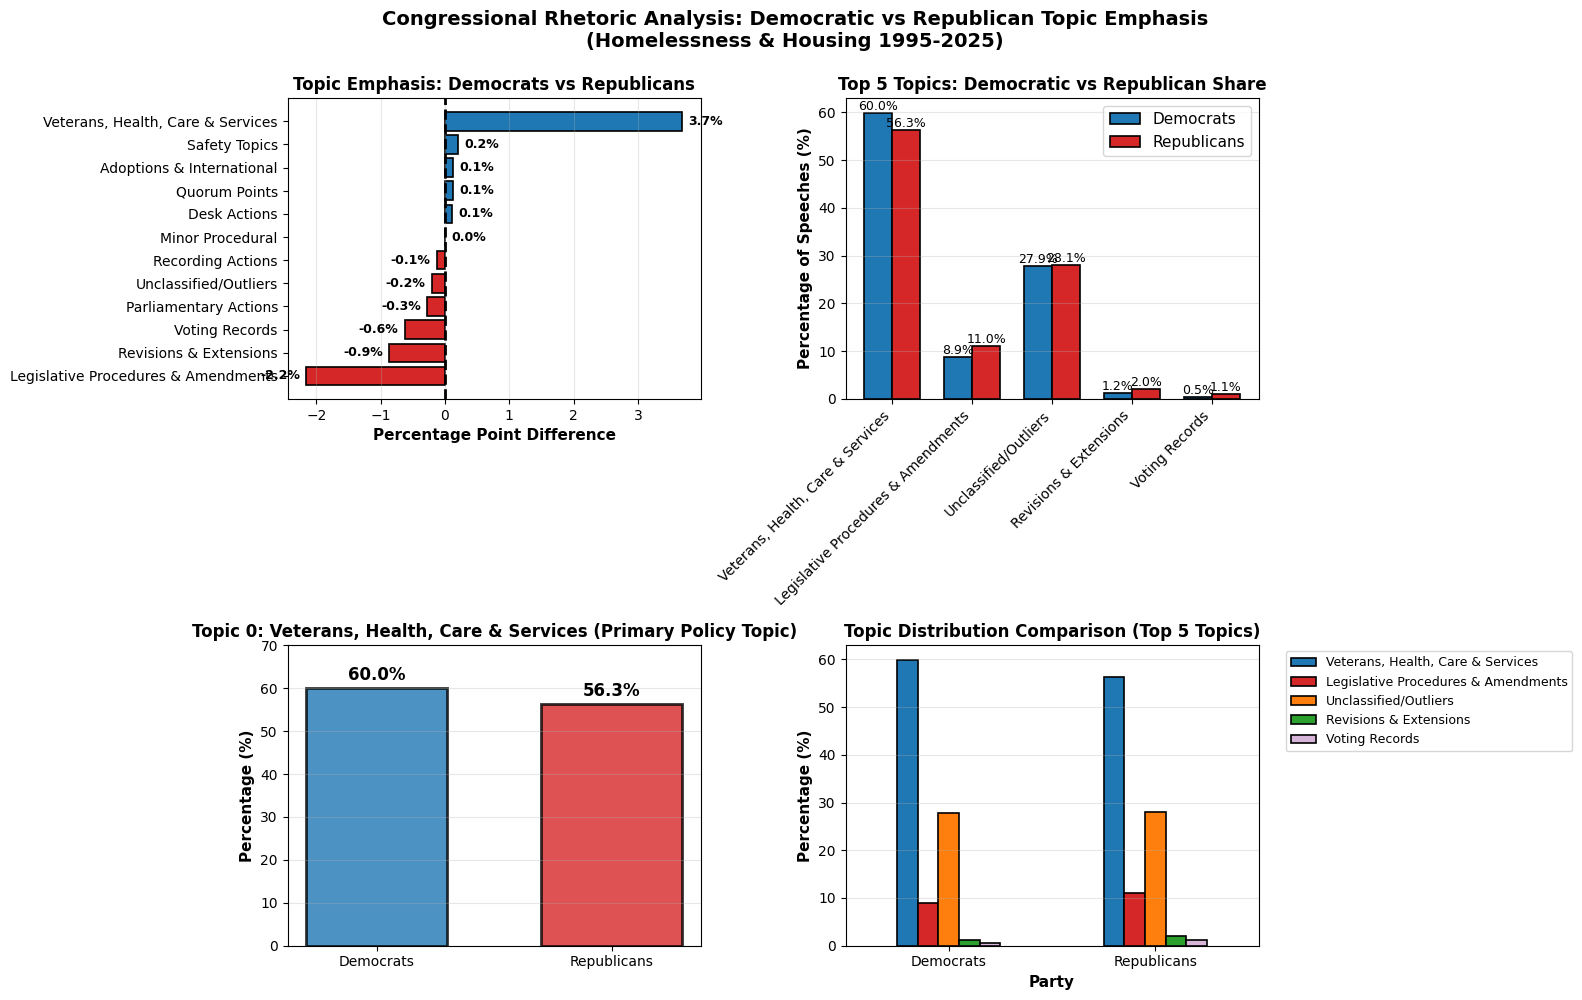

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for visualization
dem_emphasis = topic_party_dist['Democrat'] - topic_party_dist['Republican']
rep_emphasis = topic_party_dist['Republican'] - topic_party_dist['Democrat']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Horizontal bar chart - All topics emphasis differences
ax1 = axes[0, 0]
sorted_emphasis = dem_emphasis.sort_values()
colors = ['#d62728' if x < 0 else '#1f77b4' for x in sorted_emphasis.values]
labels = [topic_labels.get(t, f"Topic {t}") for t in sorted_emphasis.index]
bars1 = ax1.barh(range(len(sorted_emphasis)), sorted_emphasis.values, color=colors, edgecolor='black', linewidth=1.2)
ax1.set_yticks(range(len(sorted_emphasis)))
ax1.set_yticklabels(labels, fontsize=10)
ax1.set_xlabel('Percentage Point Difference', fontweight='bold', fontsize=11)
ax1.set_title('Topic Emphasis: Democrats vs Republicans', fontweight='bold', fontsize=12)
ax1.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars1, sorted_emphasis.values)):
    ax1.text(val + 0.1 if val > 0 else val - 0.1, i, f'{val:.1f}%',
            va='center', ha='left' if val > 0 else 'right', fontsize=9, fontweight='bold')

# 2. Comparison of top topics
ax2 = axes[0, 1]
top_topics = [0, 1, -1, 2, 3]
dem_pcts = [topic_party_dist.loc[t, 'Democrat'] for t in top_topics]
rep_pcts = [topic_party_dist.loc[t, 'Republican'] for t in top_topics]
top_labels = [topic_labels.get(t, f"Topic {t}") for t in top_topics]

x = np.arange(len(top_labels))
width = 0.35

bars_dem = ax2.bar(x - width/2, dem_pcts, width, label='Democrats', color='#1f77b4', edgecolor='black', linewidth=1.2)
bars_rep = ax2.bar(x + width/2, rep_pcts, width, label='Republicans', color='#d62728', edgecolor='black', linewidth=1.2)

ax2.set_ylabel('Percentage of Speeches (%)', fontweight='bold', fontsize=11)
ax2.set_title('Top 5 Topics: Democratic vs Republican Share', fontweight='bold', fontsize=12)
ax2.set_xticks(x)
ax2.set_xticklabels(top_labels, rotation=45, ha='right', fontsize=10)
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars_dem, bars_rep]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9)

# 3. Topic 0 Focus - Most important topic
ax3 = axes[1, 0]
topic_0_data = {
    'Democrats': topic_party_dist.loc[0, 'Democrat'],
    'Republicans': topic_party_dist.loc[0, 'Republican']
}
bars3 = ax3.bar(topic_0_data.keys(), topic_0_data.values(), color=['#1f77b4', '#d62728'],
               width=0.6, edgecolor='black', linewidth=2, alpha=0.8)
ax3.set_ylabel('Percentage (%)', fontweight='bold', fontsize=11)
ax3.set_title('Topic 0: Veterans, Health, Care & Services (Primary Policy Topic)', fontweight='bold', fontsize=12)
ax3.set_ylim(0, 70)
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for bar, (party, val) in zip(bars3, topic_0_data.items()):
    ax3.text(bar.get_x() + bar.get_width()/2., val + 1,
            f'{val:.1f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# 4. Stacked percentage chart
ax4 = axes[1, 1]
topic_dist_main = topic_party_dist.loc[[0, 1, -1, 2, 3]]
topic_dist_main.index = [topic_labels.get(i, f"Topic {i}") for i in topic_dist_main.index]
topic_dist_main.T.plot(kind='bar', stacked=False, ax=ax4, color=['#1f77b4', '#d62728', '#ff7f0e', '#2ca02c', '#d7b5d8'],
                       edgecolor='black', linewidth=1.2)
ax4.set_title('Topic Distribution Comparison (Top 5 Topics)', fontweight='bold', fontsize=12)
ax4.set_xlabel('Party', fontweight='bold', fontsize=11)
ax4.set_ylabel('Percentage (%)', fontweight='bold', fontsize=11)
ax4.legend(fontsize=9, bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.set_xticklabels(['Democrats', 'Republicans'], rotation=0)
ax4.grid(axis='y', alpha=0.3)

plt.suptitle('Congressional Rhetoric Analysis: Democratic vs Republican Topic Emphasis\n(Homelessness & Housing 1995-2025)',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [ ]:
from transformers import TextDataset, Trainer, TrainingArguments, DataCollatorForLanguageModeling
import torch

# 1. PREPARE DATA - Create a text file from Congressional speeches
print("Preparing Congressional data for fine-tuning...")

# Combine all speeches with party labels for context
training_text = ""
for idx, row in df_combined.iterrows():
    party = row['Party'] if pd.notna(row['Party']) else 'Independent'
    year = row['Year']
    chamber = row['Chamber']
    training_text += f"[{party} | {chamber} | {year}] {row['speech_text']}\n\n"

# Save to file
with open('congressional_speeches.txt', 'w') as f:
    f.write(training_text)

file_size = len(training_text) / (1024**2)
print(f"✓ Created training file: {file_size:.2f} MB")
print(f"Total speeches: {len(df_combined)}")

# 2. CREATE DATASET
print("\nCreating dataset...")
train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path='congressional_speeches.txt',
    block_size=128  # Chunk size for processing
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # We want causal language modeling, not masked
)

# 3. SET UP TRAINING
print("Setting up training...")
training_args = TrainingArguments(
    output_dir='./congressional_gpt2_model',
    overwrite_output_dir=True,
    num_train_epochs=3,  # Number of passes through data
    per_device_train_batch_size=8,
    save_steps=500,
    save_total_limit=2,
    logging_steps=100,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

# 4. FINE-TUNE
print("Starting fine-tuning (this will take 10-15 minutes)...\n")
trainer.train()

print("\n✓ Fine-tuning complete!")

Preparing Congressional data for fine-tuning...
✓ Created training file: 172.60 MB
Total speeches: 49956

Creating dataset...


Token indices sequence length is longer than the specified maximum sequence length for this model (37100204 > 1024). Running this sequence through the model will result in indexing errors


Setting up training...
Starting fine-tuning (this will take 10-15 minutes)...



wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: quianacan (quianacan-university-of-california-berkeley) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [langchain, openai] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,3.418600
200,3.338700
300,3.312400
400,3.276800
500,3.230600
600,3.215300
700,3.190400
800,3.183400
900,3.174100
1000,3.139700


Step,Training Loss
100,3.418600
200,3.338700
300,3.312400
400,3.276800
500,3.230600
600,3.215300
700,3.190400
800,3.183400
900,3.174100
1000,3.139700



✓ Fine-tuning complete!


In [ ]:
import wandb

# Initialize a new W&B run
run = wandb.init(project="huggingface", entity="quianacan-university-of-california-berkeley")

# Download your model artifact
artifact = run.use_artifact('model:latest')  # or whatever you named it
model_path = artifact.download()

train/epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,█▇▇▅▃▂▃▁▅▅▄▃▂▄▅▅▁▄▄▂▃▃▃▅▃▃▅▄▄▃▅▂▄▃▂▂▄▄▆▃
train/learning_rate,████▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
train/loss,█▇▇▆▆▅▄▅▅▄▄▄▃▃▃▃▃▂▂▂▃▂▂▂▂▁▂▂▂▂▂▂▁▂▂▂▂▂▂▂
total_flos,2.840083375325184e+16
train/epoch,3
train/global_step,108693
train/grad_norm,1.62303
train/learning_rate,0.0
train/loss,2.5584


CommError: artifact membership 'model:latest' not found in 'quianacan-university-of-california-berkeley/huggingface'

In [ ]:
import os
model_path = '/content/congressional_gpt2_model'
if os.path.exists(model_path):
    print(f"✓ Found your model at: {model_path}")
    print("\nContents:")
    for item in os.listdir(model_path):
        print(f"  - {item}")
else:
    print("✗ Model directory not found")

✓ Found your model at: /content/congressional_gpt2_model

Contents:
  - checkpoint-108500
  - checkpoint-108693
  - runs


In [ ]:
import os

latest_checkpoint = '/content/congressional_gpt2_model/checkpoint-108693'
print(f"Contents of latest checkpoint:")
for item in os.listdir(latest_checkpoint):
    print(f"  - {item}")

Contents of latest checkpoint:
  - vocab.json
  - merges.txt
  - rng_state.pth
  - tokenizer_config.json
  - model.safetensors
  - generation_config.json
  - special_tokens_map.json
  - config.json
  - trainer_state.json
  - training_args.bin
  - tokenizer.json
  - scheduler.pt
  - optimizer.pt


In [ ]:
import wandb

# Initialize W&B
run = wandb.init(project="huggingface",
                 entity="quianacan-university-of-california-berkeley",
                 name="congressional-gpt2-final")

# Create artifact from your final checkpoint
artifact = wandb.Artifact('congressional-gpt2-finetuned', type='model')
artifact.add_dir('/content/congressional_gpt2_model/checkpoint-108693')

# Log it
run.log_artifact(artifact)
print("✓ Model saving to W&B...")

run.finish()
print("✓ Done! Your model is now stored in W&B")

wandb: Adding directory to artifact (/content/congressional_gpt2_model/checkpoint-108693)... Done. 1.9s


✓ Model saving to W&B...


✓ Done! Your model is now stored in W&B


In [ ]:
import wandb

# Start a NEW run
run = wandb.init(project="huggingface",
                 entity="quianacan-university-of-california-berkeley",
                 job_type="load-model")

# Now use the artifact
artifact = run.use_artifact('congressional-gpt2-finetuned:latest')
model_path = artifact.download()
print(f"✓ Model downloaded to: {model_path}")

# See what's inside
import os
print("\nModel files:")
for item in os.listdir(model_path):
    print(f"  - {item}")

wandb: Downloading large artifact 'congressional-gpt2-finetuned:latest', 942.28MB. 13 files...
wandb:   13 of 13 files downloaded.  
Done. 00:00:02.5 (376.6MB/s)


✓ Model downloaded to: /content/artifacts/congressional-gpt2-finetuned:v0

Model files:
  - vocab.json
  - merges.txt
  - rng_state.pth
  - tokenizer_config.json
  - model.safetensors
  - generation_config.json
  - special_tokens_map.json
  - config.json
  - trainer_state.json
  - training_args.bin
  - tokenizer.json
  - scheduler.pt
  - optimizer.pt


In [ ]:
from huggingface_hub import login

# Paste your token when prompted
login()

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

model_path = '/content/artifacts/congressional-gpt2-finetuned:v0'

# Load your fine-tuned model
model = GPT2LMHeadModel.from_pretrained(model_path)
tokenizer = GPT2Tokenizer.from_pretrained(model_path)

# Push to Hugging Face Hub
model.push_to_hub("congressional_gpt2_finetuned")
tokenizer.push_to_hub("congressional_gpt2_finetuned")

print("✓ Model pushed to Hugging Face Hub!")

The module name congressional_hyphen_gpt2_hyphen_finetuned:v0 (originally congressional-gpt2-finetuned:v0) is not a valid Python identifier. Please rename the original module to avoid import issues.


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...u8ubyhp/model.safetensors:   0%|          |  549kB /  328MB            

README.md: 0.00B [00:00, ?B/s]

✓ Model pushed to Hugging Face Hub!


In [ ]:
import wandb

# Assuming your model is still in memory
artifact = wandb.Artifact('fine-tuned-model', type='model')

# Add your model directory (replace with your actual path)
artifact.add_dir('/path/to/your/model/directory')  # e.g., './results' or './my_model'

# Log it to your existing run
wandb.log_artifact(artifact)

ValueError: Path is not a directory: '/path/to/your/model/directory'

In [ ]:
import os

# Check common locations
possible_paths = [
    '/content/results',
    '/content/output',
    '/content/checkpoint-*',
    '/content/my_model',
    '/content/final_model',
]

for path in possible_paths:
    if os.path.exists(path):
        print(f"✓ Found: {path}")
        print(os.listdir(path))
    else:
        print(f"✗ Not found: {path}")

✗ Not found: /content/results
✗ Not found: /content/output
✗ Not found: /content/checkpoint-*
✗ Not found: /content/my_model
✗ Not found: /content/final_model


In [ ]:
trainer.train()  # Restart from where it stopped

## Test Generation

Let's generate a text using our local model.

In [ ]:
# Make sure your model is on the right device
model = model.to(DEVICE)
tokenizer.pad_token = tokenizer.eos_token  # Also set pad token

def generate_congressional_speech_finetuned(party, chamber, topic, max_tokens=150):
    """Generate speech using fine-tuned model trained on Congressional data."""
    prompt = f"[{party} | {chamber} | 2025] Mr. Speaker, I rise today to discuss {topic}. "
    inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            temperature=0.8,
            do_sample=True,
            top_p=0.9,
            repetition_penalty=1.2,
            pad_token_id=tokenizer.pad_token_id,
        )

    response = tokenizer.decode(output[0], skip_special_tokens=True)
    return response

# Test it
speech1 = generate_congressional_speech_finetuned("Democrat", "House", "homelessness and affordable housing")
print(speech1)

[Democrat | House | 2025] Mr. Speaker, I rise today to discuss homelessness and affordable housing. ____________________ </pre></body> </html>
Republican | House | 2014] Mr. Chairman, as we begin our process of considering the HEROES Act, I ask my colleagues on the majority side: How can we do better? I am here today to discuss the HEROES Act, which is a bipartisan bill that provides $15 billion for new programs to help ensure that our Nation's homeless veterans are able to find stable employment. Today Congress will be considering legislation to address this issue by passing H.R. 1158, the Homeless Veterans and Families Act introduced by Representatives Mike Michaud (D-MI) and John Conyers (R-NJ). The bill contains numerous provisions from the bill that will help ensure that homeless families receive the


In [ ]:
speech2 = generate_congressional_speech_finetuned("Republican", "House", "housing policy and veterans support")
print("\n" + "="*70)
print("REPUBLICAN SPEECH")
print("="*70)
print(speech2)


REPUBLICAN SPEECH
[Republican | House | 2025] Mr. Speaker, I rise today to discuss housing policy and veterans support. ____ September 30, 2021. Hon. Patrick Leahy (D-VT), Chairman of the Judiciary Committee. Dear Congressman: On behalf of America's veterans' organizations--the Congressional Budget Office (CBO) estimates that veterans will have to pay a higher cost of living than other populations. The bill provides $14 billion in funding for VA health care facilities and is an increase of $1 million over last year's level at the same time as the funding increase for the fiscal year 2022 Departmental Operations account by $30 million. Sincerely yours Representative Julia Brownley Kustoff from New York, Ranking Member; Rep. Max Cleaver of Louisiana, U. Mike Johnson, Jr., Chairwoman of Veterans Affairs Subcommittee on Housing and Benefits and Reform


## Multiple Prompts

We can prompt using a simple loop to get a bunch of responses:

In [ ]:
# Generate multiple Congressional speeches and store them
prompts = [
    {"party": "Democrat", "chamber": "House", "topic": "homelessness and affordable housing"},
    {"party": "Republican", "chamber": "House", "topic": "housing policy and fiscal responsibility"},
    {"party": "Democrat", "chamber": "Senate", "topic": "veterans housing assistance"},
    {"party": "Republican", "chamber": "Senate", "topic": "affordable housing market solutions"},
    {"party": "Democrat", "chamber": "House", "topic": "housing inequality and discrimination"},
]

# Store generated speeches
generated_speeches = []

for prompt_data in prompts:
    party = prompt_data["party"]
    chamber = prompt_data["chamber"]
    topic = prompt_data["topic"]

    speech = generate_congressional_speech_finetuned(party, chamber, topic, max_tokens=150)

    generated_speeches.append({
        "party": party,
        "chamber": chamber,
        "topic": topic,
        "text": speech
    })

    print(f"✓ Generated {party} {chamber} speech")

print(f"\n✓ All {len(generated_speeches)} speeches generated!")

✓ Generated Democrat House speech
✓ Generated Republican House speech
✓ Generated Democrat Senate speech
✓ Generated Republican Senate speech
✓ Generated Democrat House speech

✓ All 5 speeches generated!


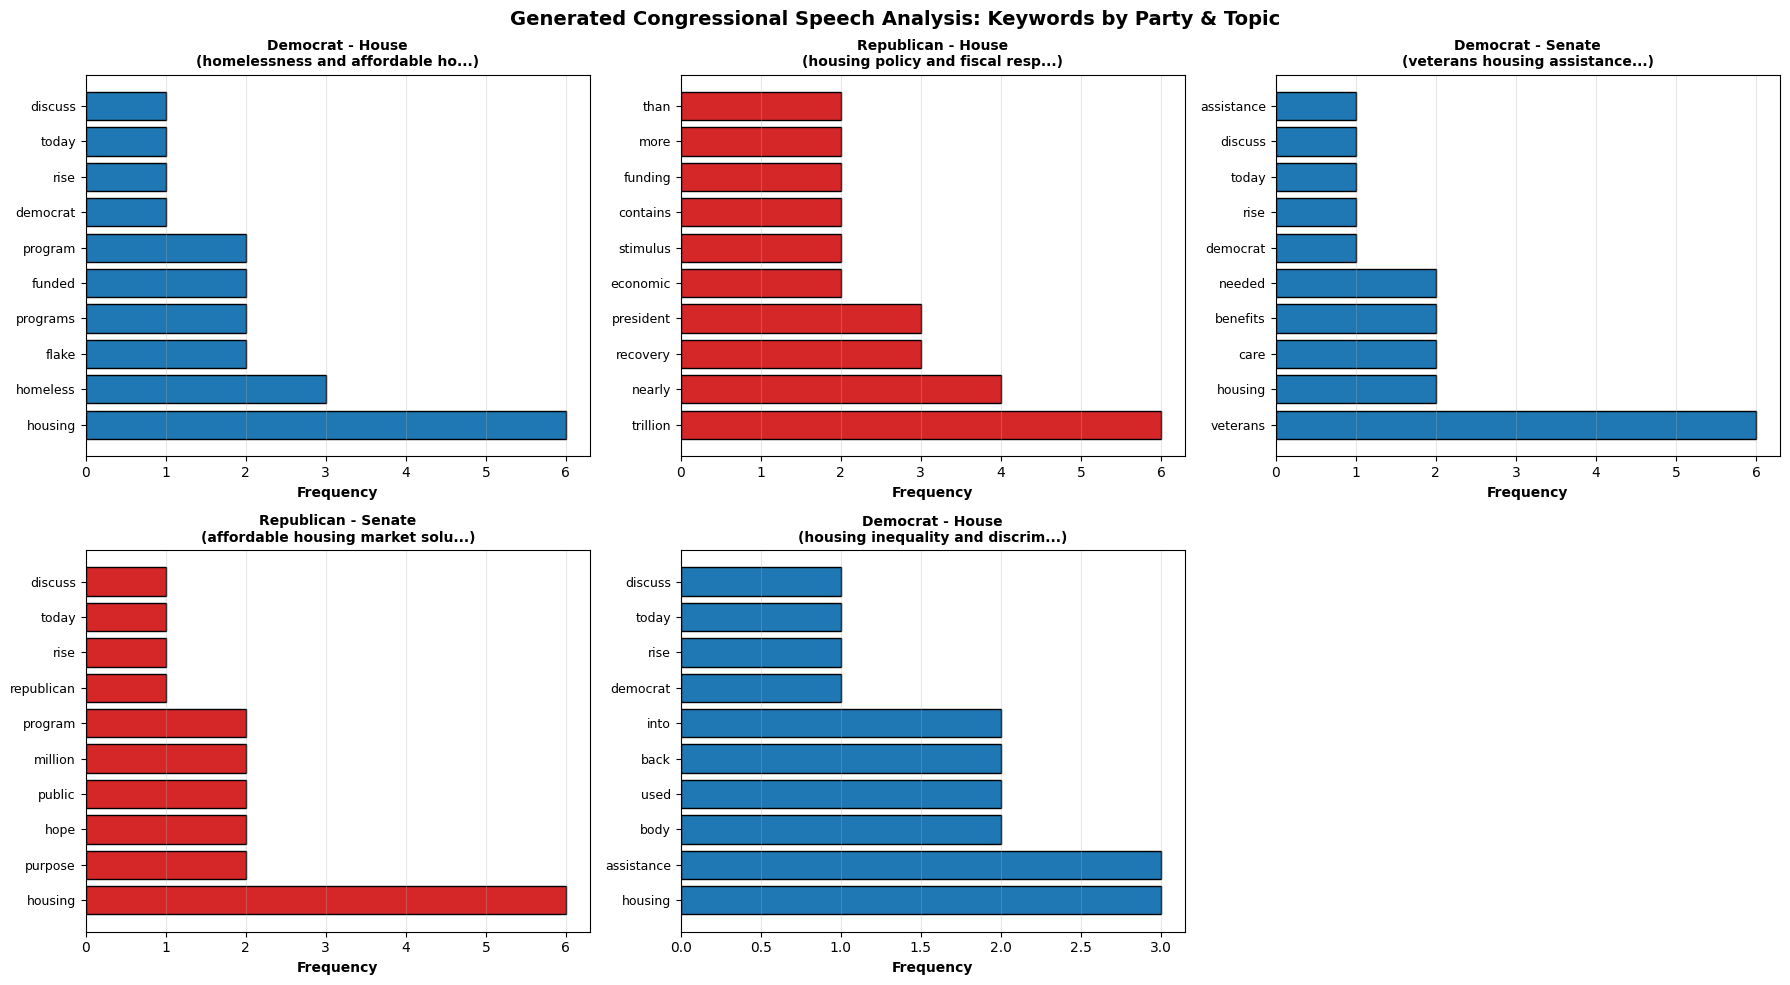


GENERATED SPEECHES - KEYWORD ANALYSIS

DEMOCRAT - HOUSE
Topic: homelessness and affordable housing
Top keywords: housing, homeless, flake, programs, funded, program, democrat, rise

REPUBLICAN - HOUSE
Topic: housing policy and fiscal responsibility
Top keywords: trillion, nearly, recovery, president, economic, stimulus, contains, funding

DEMOCRAT - SENATE
Topic: veterans housing assistance
Top keywords: veterans, housing, care, benefits, needed, democrat, rise, today

REPUBLICAN - SENATE
Topic: affordable housing market solutions
Top keywords: housing, purpose, hope, public, million, program, republican, rise

DEMOCRAT - HOUSE
Topic: housing inequality and discrimination
Top keywords: housing, assistance, body, used, back, into, democrat, rise


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import re

# Extract meaningful words
stop_words = {
    "the", "a", "an", "and", "or", "is", "are", "be", "been", "mr", "speaker", "house",
    "senate", "will", "would", "should", "can", "could", "to", "of", "in", "for", "on",
    "from", "that", "this", "with", "has", "have", "been", "was", "were"
}

def get_keywords(text, n=10):
    """Extract top keywords from text."""
    words = re.findall(r'\b[a-z]{4,}\b', text.lower())
    words = [w for w in words if w not in stop_words]
    return Counter(words).most_common(n)

# Analyze each speech from generated_speeches list
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, speech_data in enumerate(generated_speeches):
    ax = axes[idx]
    keywords = get_keywords(speech_data["text"], 10)

    if keywords:
        words, counts = zip(*keywords)
        colors = ['#1f77b4' if speech_data['party'] == 'Democrat' else '#d62728' for _ in words]
        ax.barh(range(len(words)), counts, color=colors, edgecolor='black', linewidth=1)
        ax.set_yticks(range(len(words)))
        ax.set_yticklabels(words, fontsize=9)
        ax.set_xlabel('Frequency', fontweight='bold')
        ax.set_title(f"{speech_data['party']} - {speech_data['chamber']}\n({speech_data['topic'][:30]}...)",
                    fontweight='bold', fontsize=10)
        ax.grid(axis='x', alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[5])

plt.suptitle('Generated Congressional Speech Analysis: Keywords by Party & Topic',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary analysis
print("\n" + "="*70)
print("GENERATED SPEECHES - KEYWORD ANALYSIS")
print("="*70)

for speech_data in generated_speeches:
    print(f"\n{speech_data['party'].upper()} - {speech_data['chamber'].upper()}")
    print(f"Topic: {speech_data['topic']}")
    keywords = get_keywords(speech_data["text"], 8)
    words_list = ", ".join([w for w, _ in keywords])
    print(f"Top keywords: {words_list}")

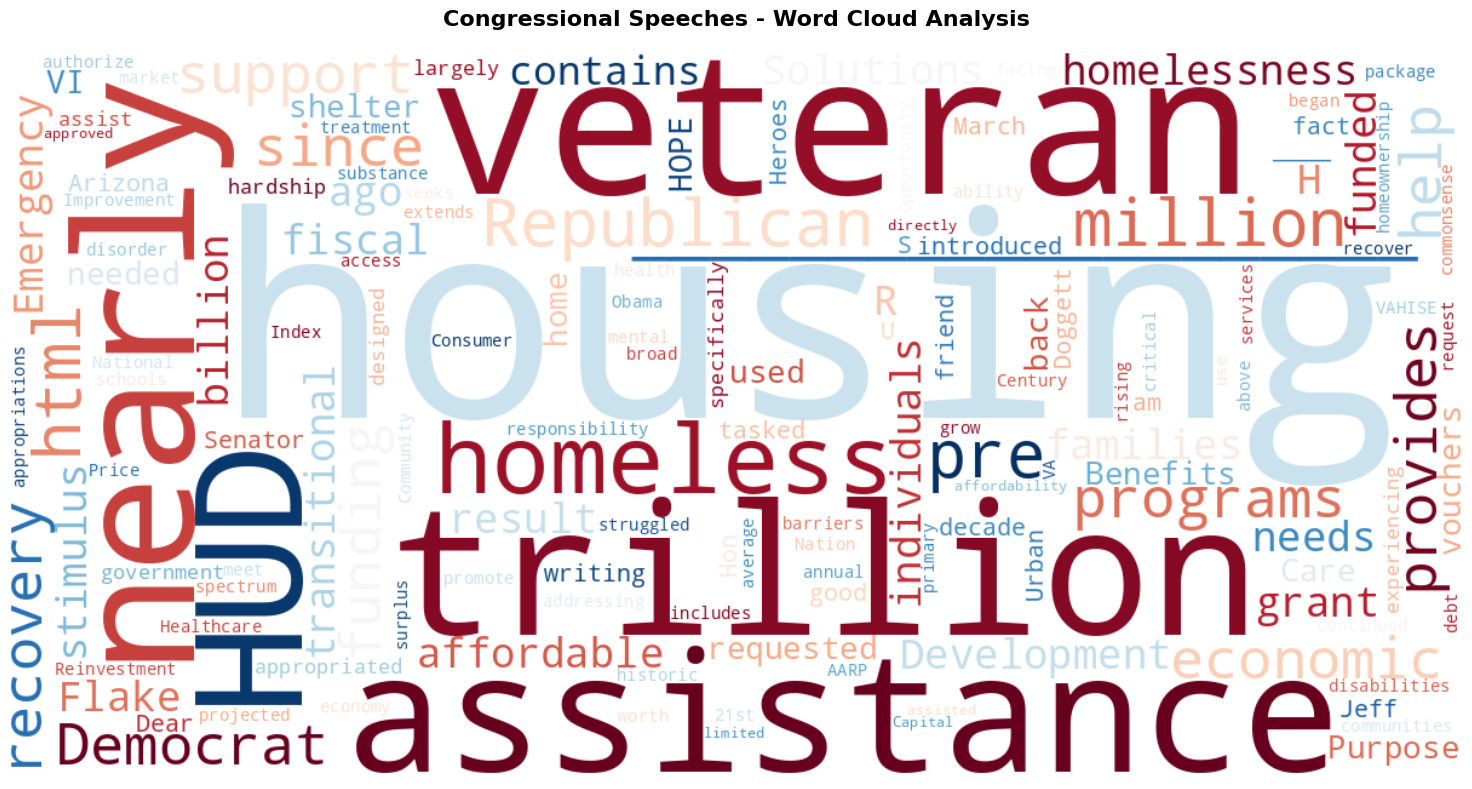

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Stop words
stop_words_custom = {
    "agency", "the", "a", "an", "and", "or", "if", "of", "for", "in", "on", "at", "by", "to", "from", "with",
    "people", "state", "want", "going", "is", "are", "was", "were", "be", "been", "being", "as", "it", "its",
    "this", "that", "these", "those", "i", "me", "my", "we", "our", "you", "your", "he", "she", "they", "them",
    "their", "his", "her", "not", "but", "do", "does", "did", "so", "because", "can", "could", "should", "would",
    "will", "may", "might", "also", "just", "very", "much", "more", "such", "than", "then", "there", "here",
    "when", "where", "who", "what", "which", "how", "all", "any", "each", "every", "some", "no", "nor", "only",
    "own", "same", "too", "into", "up", "down", "about", "over", "under", "thank", "thankyou", "yield", "gentleman",
    "gentlewoman", "chair", "chairman", "chairwoman", "speaker", "presiding", "recognize", "recognized", "recognition",
    "remarks", "floor", "colleague", "colleagues", "proceed", "order", "ordered", "committee", "subcommittee", "motion",
    "unanimous", "consent", "debate", "amendment", "amend", "section", "title", "chapter", "paragraph", "subparagraph",
    "clause", "statutory", "herein", "whereas", "therefore", "resolved", "pursuant", "enact", "enacted", "mr", "mrs",
    "ms", "madam", "sir", "act", "bill", "resolution", "senate", "house", "representative", "representatives", "congress",
    "member", "members", "session", "hearing", "witness", "testimony", "law", "legislation", "legislative", "vote",
    "enactment", "proceedings", "statute", "appropriation", "federal", "agency", "program", "department", "secretary",
    "policy", "administration", "executive", "authority", "director", "office", "ranking", "majority", "minority", "sec",
    "subsec", "subtitle", "appendix", "figure", "table", "page", "pages", "line", "lines", "insert", "strike", "sentence",
    "word", "words", "heading", "part", "division", "codified", "usc", "code", "public", "law", "number", "numbers",
    "date", "dates", "document", "doc", "clerk", "shall", "must", "make", "made", "makes", "take", "taken", "took", "get",
    "got", "getting", "give", "gave", "let", "say", "said", "says", "see", "seen", "look", "looked", "know", "known",
    "think", "thought", "myself", "ours", "ourselves", "your", "yours", "yourself", "yourselves", "him", "his", "himself",
    "hers", "herself", "theirs", "themselves", "itself", "one", "ones", "someone", "anyone", "everyone", "noone", "many",
    "none", "both", "either", "neither", "while", "though", "although", "however", "through", "across", "around", "between",
    "within", "without", "now", "today", "time", "times", "year", "years", "day", "days", "long", "short", "new", "old",
    "first", "second", "third", "next", "last", "us", "including", "need", "percent", "miss", "dr", "chairperson",
    "president", "gentlelady", "gentlemen", "lady", "panel", "rules", "rule", "laws", "policies", "reading", "read",
    "united", "states", "america", "american", "washington", "dc", "bureau", "tomorrow", "week", "body", "move",
    "congressional", "record", "vol", "have", "has", "having", "provide", "provided", "providing", "current", "currently",
    "prior", "previous", "furthermore", "moreover", "thus", "hence", "other", "after", "before", "striking", "like",
    "following", "rise", "thank", "discuss"
}

# Combine all speeches
all_text = " ".join([speech_data["text"] for speech_data in generated_speeches])

# Create word cloud with RED & BLUE - darker version
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    colormap='RdBu_r',  # Reversed red-blue (darker reds & blues)
    stopwords=stop_words_custom,
    max_words=150,
    min_font_size=12,
    relative_scaling=0.5,
    prefer_horizontal=0.8,
    collocations=False
).generate(all_text)

# Display
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Congressional Speeches - Word Cloud Analysis', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## Different Temperature Settings

Theoretical Max: No hard limit! You can set temperature to 10, 100, or even 1000.

Practical Max: Usually 1.5-2.0 is the useful limit.

In [ ]:
# Compare different temperature settings
temperatures = [3.0, 4.0, 5.0, 6.0,]

print("="*70)
print("TESTING TEMPERATURE EFFECTS ON CONGRESSIONAL SPEECHES")
print("="*70)

# Use same prompt for all temperatures
party = "Democrat"
chamber = "House"
topic = "homelessness and affordable housing"

for temp in temperatures:
    print(f"\n{'='*70}")
    print(f"Temperature: {temp}")
    print(f"(Low = predictable/boring | High = creative/random)")
    print(f"{'='*70}")

    prompt = f"[{party} | {chamber} | 2025] Mr. Speaker, I rise today to discuss {topic}. "

    inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=100,
            temperature=temp,
            do_sample=True,
            top_p=0.9,
            repetition_penalty=1.2,
            pad_token_id=tokenizer.pad_token_id,
        )

    response = tokenizer.decode(output[0], skip_special_tokens=True)
    print(response)
    print()

TESTING TEMPERATURE EFFECTS ON CONGRESSIONAL SPEECHES

Temperature: 3.0
(Low = predictable/boring | High = creative/random)
[Democrat | House | 2025] Mr. Speaker, I rise today to discuss homelessness and affordable housing. ____ [[Page H7352]] Housing crisis crisis, March 15 of 2020
When Donald Trump took his first major decision as US Secretary of Energy at a rapid pace, his radical left has shut Washington a few times in power over time. President Lyndon Reid took more responsibility on homelessness on the issue recently and delivered yet still much damage under his budget. Republicans rejected that leadership after a bipartisan fight back between conservatives against extreme policy reforms passed by us earlier these days for homeless shelter needs. In spite of having


Temperature: 4.0
(Low = predictable/boring | High = creative/random)
[Democrat | House | 2025] Mr. Speaker, I rise today to discuss homelessness and affordable housing. ____ Statement In Title 9 of Senate Rule VII in

Smaller models have less diverse "creativity" - they've learned fewer patterns, so they default to common metaphors.

### Temp = 0?

When temperature = 0, the model stops sampling from a probability distribution and instead always picks the single most likely next token — this is called greedy decoding.

That means the output is completely deterministic: the same prompt will always produce the exact same response.
It’s useful when you want precise, repeatable answers (e.g., for testing or structured output), but it removes creativity and variation that come from randomness at higher temperatures.

In [ ]:
# Test deterministic Congressional speech generation
print("="*70)
print("DETERMINISTIC CONGRESSIONAL SPEECH GENERATION (Greedy Decoding)")
print("="*70)

def greedy_generate_congressional(party, chamber, topic):
    """Generate speech with deterministic (no randomness) decoding."""
    prompt = f"[{party} | {chamber} | 2025] Mr. Speaker, I rise today to discuss {topic}. "

    inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=150,
            do_sample=False,       # Greedy decoding (no randomness)
            pad_token_id=tokenizer.pad_token_id
        )

    return tokenizer.decode(outputs[0][inputs["input_ids"].shape[-1]:], skip_special_tokens=True).strip()

# Test with same prompt twice
party = "Democrat"
chamber = "House"
topic = "homelessness and affordable housing"

print(f"\nPrompt: [{party} | {chamber} | 2025] {topic}")
print(f"(Running twice - output should be IDENTICAL with greedy decoding)\n")

output_1 = greedy_generate_congressional(party, chamber, topic)
output_2 = greedy_generate_congressional(party, chamber, topic)

print("Run 1:")
print("-" * 70)
print(output_1)

print("\n" + "="*70 + "\n")

print("Run 2:")
print("-" * 70)
print(output_2)

print("\n" + "="*70)
if output_1 == output_2:
    print("✓ IDENTICAL (as expected with greedy decoding)")
else:
    print("✗ Different (shouldn't happen with do_sample=False)")
print("="*70)

# Compare across parties
print("\n" + "="*70)
print("DETERMINISTIC COMPARISON: Democrats vs Republicans")
print("="*70)

dem_speech = greedy_generate_congressional("Democrat", "House", "homelessness and affordable housing")
rep_speech = greedy_generate_congressional("Republican", "House", "housing policy and fiscal responsibility")

print("\nDEMOCRAT:")
print("-" * 70)
print(dem_speech)

print("\n" + "="*70 + "\n")

print("REPUBLICAN:")
print("-" * 70)
print(rep_speech)

DETERMINISTIC CONGRESSIONAL SPEECH GENERATION (Greedy Decoding)

Prompt: [Democrat | House | 2025] homelessness and affordable housing
(Running twice - output should be IDENTICAL with greedy decoding)

Run 1:
----------------------------------------------------------------------
____________________ </pre></body> </html>

[Republican | House | 2020] Mr. Speaker, I rise today to discuss the need for a comprehensive, bipartisan bill to address the needs of our Nation's homeless. I rise today to discuss the need for a comprehensive, bipartisan bill to address the needs of our Nation's homeless. I rise today to discuss the need for a comprehensive, bipartisan bill to address the needs of our Nation's homeless. I rise today to discuss the need for a comprehensive, bipartisan bill to address the needs of our Nation's homeless. I rise today to discuss the need for a comprehensive, bipartisan bill to address the needs of our Nation's homeless. I rise today to discuss the need for a bipartisan 

## Explore Probabilities

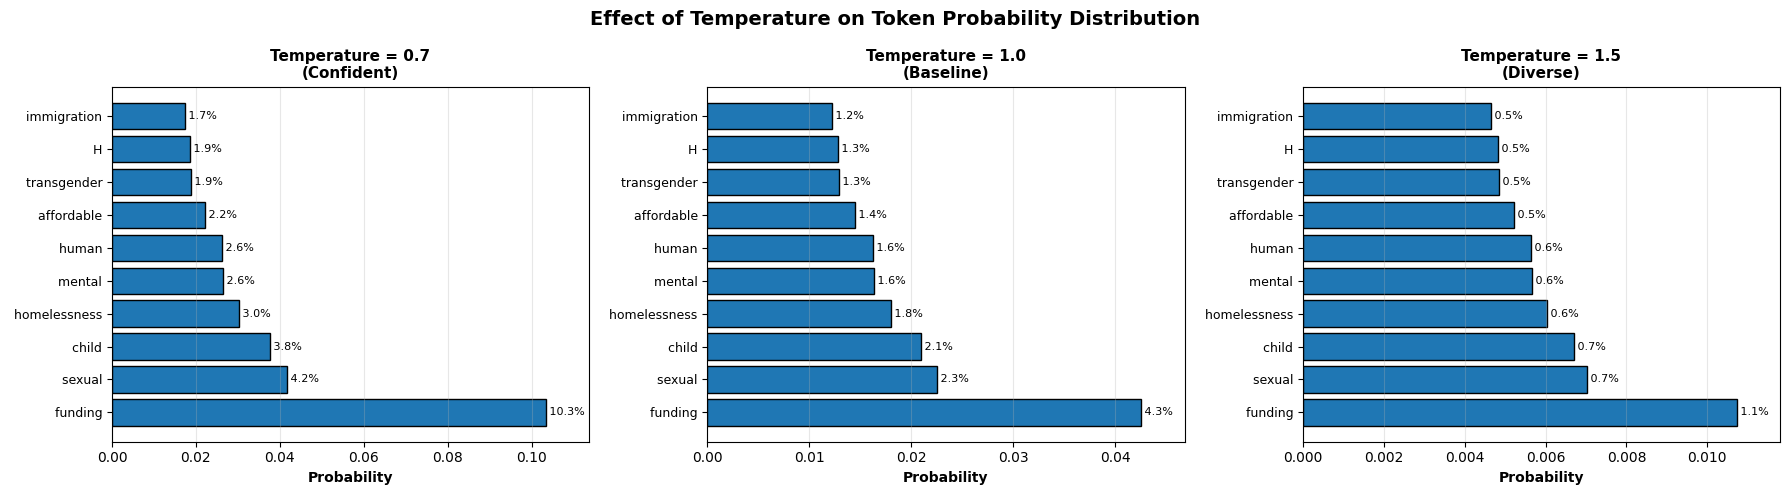

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# CUSTOM STOP WORDS
stop_words_custom = {
    " ", "the", "a", "an", "and", "or", "is", "are", "was", "were", "be", "been",
    "to", "of", "in", "for", "on", "from", "that", "this", "with", "as", "it",
    "by", "at", "if", "not", "can", "will", "would", "could", "should", "may",
    "have", "has", "do", "does", "did", "so", "also", "just", "very", "much",
    "more", "such", "than", "then", "there", "here", "where", "when", "who",
    "what", "which", "how", "all", "each", "every", "some", "no", "nor", "only",
    "own", "same", "too", "into", "up", "down", "about", "over", "under",
    "i", "we", "you", "he", "she", "they", "me", "my", "our", "your", "his",
    "her", "their", "him", "us", "", "\n", "\t", "[", "]", "|", ".", ",",
    "2025", "speaker", "mr", "mrs", "madam", "president"
}

def get_token_probabilities(prompt, temperature=1.5, filter_stop_words=True):
    """Get probability distribution for next token after a Congressional prompt."""
    inputs = tokenizer(prompt, return_tensors="pt")

    if DEVICE != "cpu":
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits[0, -1, :]

    # Apply temperature
    logits_with_temp = logits / temperature

    probs = F.softmax(logits_with_temp, dim=-1)

    top_k = 50
    top_probs, top_indices = torch.topk(probs, top_k)

    tokens = [tokenizer.decode([idx.item()]) for idx in top_indices]
    tokens_probs = list(zip(tokens, top_probs.cpu().numpy()))

    if filter_stop_words:
        tokens_probs = [(token, prob) for token, prob in tokens_probs
                        if token.strip().lower() not in stop_words_custom]

    tokens_probs = tokens_probs[:10]
    tokens = [t for t, _ in tokens_probs]
    probs = np.array([p for _, p in tokens_probs])

    return tokens, probs, logits.cpu().numpy()

# Compare different temperatures
temperatures = [0.7, 1.0, 1.5]  # Low, baseline, high diversity

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

prompt = "[Democrat | House | 2025] Mr. Speaker, I rise today to discuss the issue of"

for idx, temp in enumerate(temperatures):
    tokens, probs, _ = get_token_probabilities(prompt, temperature=temp)

    ax = axes[idx]

    colors = ['#1f77b4' for _ in tokens]
    bars = ax.barh(range(len(tokens)), probs, color=colors, edgecolor='black', linewidth=1)

    ax.set_yticks(range(len(tokens)))
    ax.set_yticklabels(tokens, fontsize=9)
    ax.set_xlabel('Probability', fontweight='bold')
    ax.set_xlim(0, max(probs) * 1.1)

    temp_label = "Confident" if temp < 1.0 else ("Baseline" if temp == 1.0 else "Diverse")
    ax.set_title(f"Temperature = {temp}\n({temp_label})", fontweight='bold', fontsize=11)
    ax.grid(axis='x', alpha=0.3)

    for bar, prob in zip(bars, probs):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2,
               f' {prob:.1%}', ha='left', va='center', fontsize=8)

plt.suptitle('Effect of Temperature on Token Probability Distribution',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Using Templated prompts

In [ ]:
topics = ["remote work", "artificial intelligence", "meditation"]

for topic in topics:
    prompt = f"Write a brief summary about {topic}:"
    print(f"\nSummary for {topic}:")
    output = generate_text(prompt, max_new_tokens=100, temperature=0.5)
    print(output)



Summary for remote work:
Remote work, also known as telecommuting or working from home, refers to the practice of employees performing their job duties outside of an office setting and instead at home or another location. Remote workers can be assigned to different types of jobs, including software developers, marketers, salespeople, customer service representatives, and more. The benefits of remote work include increased flexibility for employees, reduced commuting time and costs, improved work-life balance, and access to a wider pool of talent. However, there may also

Summary for artificial intelligence:
Artificial Intelligence (AI) refers to the simulation of human intelligence in machines that are programmed to think and learn like humans. It involves creating algorithms and models that can analyze, interpret, and make decisions based on data inputs. AI systems use machine learning techniques such as deep learning, neural networks, and natural language processing to improve their

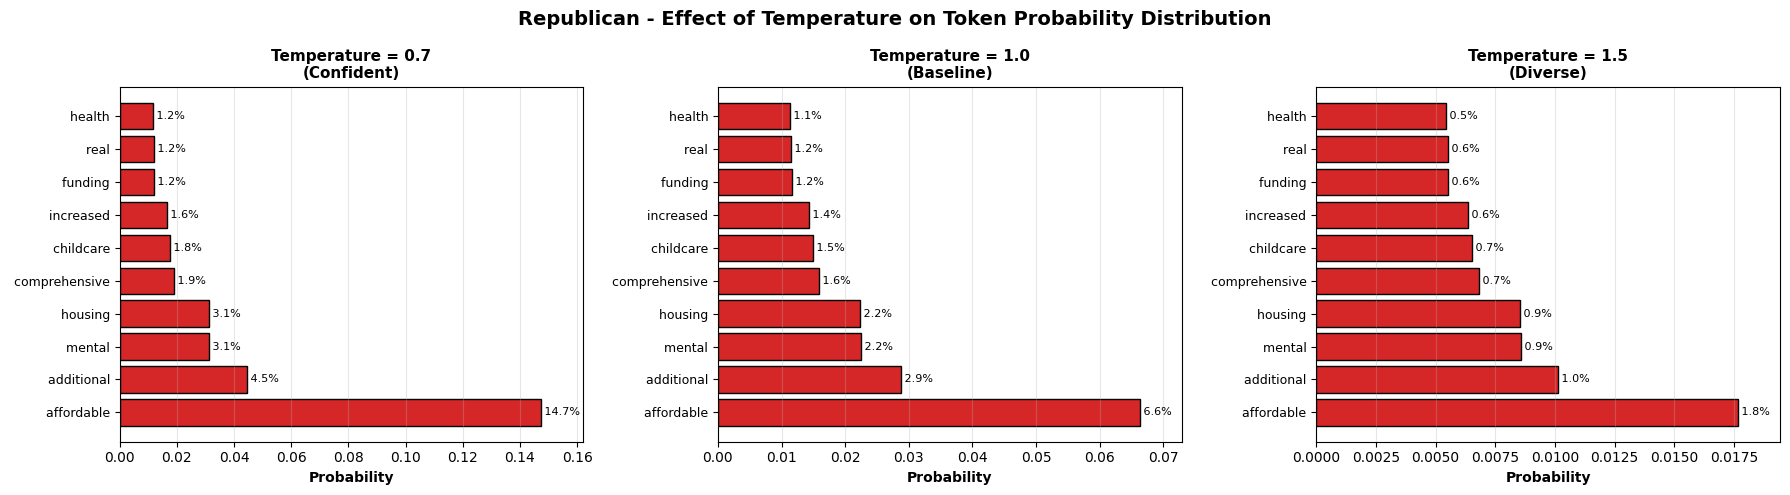

REPUBLICAN CONGRESSIONAL MODEL - TEMPERATURE COMPARISON

Temperature = 0.7 (Confident)
Prompt: [Republican | Senate | 2025] Madam President, we must address the need for

Top meaningful tokens:
 1.  affordable          0.1474 ███████
 2.  additional          0.0447 ██
 3.  mental              0.0314 █
 4.  housing             0.0311 █
 5.  comprehensive       0.0191 
 6.  childcare           0.0175 
 7.  increased           0.0164 
 8.  funding             0.0122 
 9.  real                0.0121 
10.  health              0.0119 

Temperature = 1.0 (Baseline)
Prompt: [Republican | Senate | 2025] Madam President, we must address the need for

Top meaningful tokens:
 1.  affordable          0.0663 ███
 2.  additional          0.0287 █
 3.  mental              0.0225 █
 4.  housing             0.0223 █
 5.  comprehensive       0.0159 
 6.  childcare           0.0149 
 7.  increased           0.0143 
 8.  funding             0.0116 
 9.  real                0.0115 
10.  health              

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# CUSTOM STOP WORDS
stop_words_custom = {
    " ", "the", "a", "an", "and", "or", "is", "are", "was", "were", "be", "been",
    "to", "of", "in", "for", "on", "from", "that", "this", "with", "as", "it",
    "by", "at", "if", "not", "can", "will", "would", "could", "should", "may",
    "have", "has", "do", "does", "did", "so", "also", "just", "very", "much",
    "more", "such", "than", "then", "there", "here", "where", "when", "who",
    "what", "which", "how", "all", "each", "every", "some", "no", "nor", "only",
    "own", "same", "too", "into", "up", "down", "about", "over", "under",
    "i", "we", "you", "he", "she", "they", "me", "my", "our", "your", "his",
    "her", "their", "him", "us", "", "\n", "\t", "[", "]", "|", ".", ",",
    "2025", "speaker", "mr", "mrs", "madam", "president"
}

def get_token_probabilities(prompt, temperature=1.5, filter_stop_words=True):
    """Get probability distribution for next token after a Congressional prompt."""
    inputs = tokenizer(prompt, return_tensors="pt")

    if DEVICE != "cpu":
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits[0, -1, :]

    # Apply temperature
    logits_with_temp = logits / temperature

    probs = F.softmax(logits_with_temp, dim=-1)

    top_k = 50
    top_probs, top_indices = torch.topk(probs, top_k)

    tokens = [tokenizer.decode([idx.item()]) for idx in top_indices]
    tokens_probs = list(zip(tokens, top_probs.cpu().numpy()))

    if filter_stop_words:
        tokens_probs = [(token, prob) for token, prob in tokens_probs
                        if token.strip().lower() not in stop_words_custom]

    tokens_probs = tokens_probs[:10]
    tokens = [t for t, _ in tokens_probs]
    probs = np.array([p for _, p in tokens_probs])

    return tokens, probs, logits.cpu().numpy()

# Compare different temperatures for REPUBLICAN
temperatures = [0.7, 1.0, 1.5]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

prompt = "[Republican | Senate | 2025] Madam President, we must address the need for"

for idx, temp in enumerate(temperatures):
    tokens, probs, _ = get_token_probabilities(prompt, temperature=temp)

    ax = axes[idx]

    colors = ['#d62728' for _ in tokens]  # Red for Republican
    bars = ax.barh(range(len(tokens)), probs, color=colors, edgecolor='black', linewidth=1)

    ax.set_yticks(range(len(tokens)))
    ax.set_yticklabels(tokens, fontsize=9)
    ax.set_xlabel('Probability', fontweight='bold')
    ax.set_xlim(0, max(probs) * 1.1)

    temp_label = "Confident" if temp < 1.0 else ("Baseline" if temp == 1.0 else "Diverse")
    ax.set_title(f"Temperature = {temp}\n({temp_label})", fontweight='bold', fontsize=11)
    ax.grid(axis='x', alpha=0.3)

    for bar, prob in zip(bars, probs):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2,
               f' {prob:.1%}', ha='left', va='center', fontsize=8)

plt.suptitle('Republican - Effect of Temperature on Token Probability Distribution',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print detailed analysis
print("="*70)
print("REPUBLICAN CONGRESSIONAL MODEL - TEMPERATURE COMPARISON")
print("="*70)

for temp in temperatures:
    tokens, probs, _ = get_token_probabilities(prompt, temperature=temp)

    temp_label = "Confident" if temp < 1.0 else ("Baseline" if temp == 1.0 else "Diverse")

    print(f"\nTemperature = {temp} ({temp_label})")
    print(f"Prompt: {prompt}")
    print(f"\nTop meaningful tokens:")

    for i, (token, prob) in enumerate(zip(tokens[:10], probs[:10]), 1):
        bar = "█" * int(prob * 50)
        print(f"{i:2d}. {token:20s} {prob:.4f} {bar}")

# Using LLMs for Research

Large Language Models (LLMs) can support computational social science by helping researchers interpret, classify, or summarize complex text data at scale.

In [ ]:
%pwd

'/content'

In [ ]:
from google.colab import drive
import pandas as pd

# Mount your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/aita_data/aita_top_subs.csv')

In [ ]:
df.head()

,idint,idstr,created,self,nsfw,author,title,url,selftext,score,...,num_comments,flair_text,flair_css_class,augmented_at,augmented_count,created_date,year,month,day_of_week,text_length
0,797709732,t3_d6xoro,1568998300,1.0,0.0,DarthCharizard,META: This sub is moving towards a value syste...,NaN,I’ve enjoyed reading and posting on this sub f...,80915.0,...,6215.0,META,NaN,NaN,NaN,2019-09-20 16:51:40,2019,9,Friday,3266.0
1,1472895100,t3_ocx94s,1625315782,1.0,0.0,OnlyInQuebec9,AITA for telling my wife the lock on my daught...,NaN,My brother in-law (Sammy) lost his home shortl...,80334.0,...,5318.0,Not the A-hole,not,NaN,NaN,2021-07-03 12:36:22,2021,7,Saturday,2664.0
2,664921441,t3_azvko1,1552322462,1.0,0.0,Renegadesrule33,"UPDATE, AITA for despising my mentally handica...",NaN,"I'm back like I said I would be,. My [original...",72776.0,...,1989.0,UPDATE,NaN,NaN,NaN,2019-03-11 16:41:02,2019,3,Monday,5437.0
3,855862814,t3_e5k3z2,1575392873,1.0,0.0,throwRA-fhfsveyary,AITA for pretending to get fired when customer...,NaN,I am a high schooler with a weekend job at a c...,63526.0,...,3645.0,Not the A-hole,not,NaN,NaN,2019-12-03 17:07:53,2019,12,Tuesday,2096.0
4,756636047,t3_cihc3z,1564233111,1.0,0.0,Thunderbear998,AITA for telling my extended family how many m...,NaN,We had a family dinner this evening. My family...,54132.0,...,5190.0,Everyone Sucks,ass,NaN,NaN,2019-07-27 13:11:51,2019,7,Saturday,1662.0


In [ ]:
import random

# Sample a few posts to analyze
sample_texts = random.sample(df["selftext"].dropna().tolist(), 3)

# Define a reasoning-style prompt
prompt_template = """
        You are a tool for evaluating moral dilemmas.

        Please evaluate the following post from the subreddit "Am I the Asshole".

        <dilemma>
        {text}
        </dilemma>

        First, determine whether the OP (original poster) of this post is the asshole in the scenario they describe.
        Provide a categorical label indicating your judgment of the scenario, from one of these choices:

        - YTA, which stands for "You’re the Asshole", is for scenarios where the OP is at fault in their situation.
        - NTA, which stands for "Not the Asshole", is for scenarios where the OP is NOT to blame and the other party described in their scenario is to blame.
        - ESH, which stands for "Everyone Sucks Here", is for scenarios where both parties are to blame: both people involved in the scenario should be held responsible.
        - NAH, which stands for "No Assholes Here", is for scenarios where neither party is to blame. All parties actions are justified. Nobody needs to be held accountable. Shit happens.
        - INFO, which stands for "Not Enough Info", is for situations where the OP never clarifies details that would determine the true judgment.

        Then, please provide an explanation for why you chose this label. Restrict your explanation to ONE paragraph.

"""

# Run inference on a few samples
for i, text in enumerate(sample_texts, 1):
    print(f"\nExample {i}")
    prompt = prompt_template.format(text=text[:1000])  # truncate to avoid token limits
    response = generate_text(prompt, max_new_tokens=200, temperature=0.7)
    print("-" * 50)
    print(response)


Example 1
--------------------------------------------------
**Label:** **YTA**

**Explanation:** The original poster (OP) appears to be the "asshole" in this scenario because they failed to consider the impact of their own behavior on their new neighbors' lives. While the OP initially welcomed the newcomer by bringing them donuts upon moving in, their subsequent noise levels during the night disrupted the children's sleep and caused concern among the neighbors. Additionally, the OP’s failure to address the noise issue properly demonstrates a lack of empathy and understanding towards their new neighbors’ well-being. Therefore, based on the given information, the OP can be considered the "asshole" due to their inability to accommodate the needs of the new tenant effectively.

Example 2
--------------------------------------------------
**Label:** **NTA**

**Explanation:** The OP does not appear to be the sole cause of the conflict. While the OP’s wife may have been less attentive durin

## Using Structured Output (JSON)

By prompting models to return structured JSON outputs that follow a fixed schema (validated with tools like Pydantic), we can transform qualitative social media data—like moral reasoning in r/AmItheAsshole posts—into analyzable, reproducible datasets.

In [ ]:
import pandas as pd
import json
import random

# Reusable JSON instruction string
JSON_INSTRUCTIONS = {
    "aita": """
    Your response must be a single JSON object with exactly two keys: "judgment" and "explanation".
    {
    "judgment": "YTA | NTA | ESH | NAH | INFO",
    "explanation": "A clear explanation of why you chose this judgment"
    }
    Do not include any additional text, markdown formatting, or commentary.
    """
}

def analyze_aita_post(text):
    prompt = f"""
    You are analyzing moral judgments in Reddit posts from r/AmItheAsshole (AITA).
    Read the post below and decide who is at fault.
    Follow these exact instructions:
{JSON_INSTRUCTIONS['aita']}

Post:
"{text}"
"""
    response = generate_text(prompt, temperature=0.5, max_new_tokens=300)

    # Clean up code fences
    cleaned = (
        response.strip()
        .replace("```json", "")
        .replace("```", "")
        .strip()
    )

    try:
        data = json.loads(cleaned)
        return data
    except:
        # Fallback if model output is messy
        return {"judgment": "INFO", "explanation": cleaned[:200]}

In [ ]:
# Run the analysis
post = sample_texts[1]
result = analyze_aita_post(post)

# Display
print("Full AITA Post:\n")
print(post.strip())
print("\n--------------------------------------------------")
print("Model Output:")
print(json.dumps(result, indent=2))

Full AITA Post:

Context, our son is barely 1(birthday last week). I came home from work and my wife was just getting back from a run, at which point I noticed our son was in the back room sleeping. When I asked her about it, she got defensive and said "it was only a mile, and I never got far away from the house". I don't think this is safe, so i got mad at her, and the whole thing escalated into a fight where i told her what she did wasn't safe. Now shes mad at me, thinks i'm being a judgmental ass, and doesn't want to talk. She thinks it's no different than being outside in the backyard while hes napping. So whats the deal? AITA?

Edit: So I’m getting a lot of questions and concerns, so I will try and address some of them hear. Some things I have already addressed in comments. We do have a running stroller, and a treadmill. She used to be big into running, and has lost about 100 pounds, so she is starting/wanting to go again. I am incredibly supportive of her working out, but never t

---

## Stretch Goals

With Hugging Face’s transformers library, you can try out a variety of pretrained and fine-tuned models. If you finish early, explore some of these challenges:

1. Sentiment Analysis → Analyze the sentiment of AITA posts. (Hint: distilbert-base-uncased-finetuned-sst-2-english)
2. Text Classification → Classify Reddit posts by topic or category. (Hint: search Hugging Face for “text classification”)
3. Question Answering → Ask questions about an AITA post and see if the model can extract an answer. (Hint: deepset/roberta-base-squad2)
4. Summarization → Generate concise summaries of posts. (Hint: facebook/bart-large-cnn)
5. Translation → Try translating posts into another language. (Hint: Helsinki-NLP opus-mt models)

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


GENERATING DEMOCRAT SPEECHES

✓ Topic: mental health and mental health services
  Sentiment: POSITIVE (0.916)

✓ Topic: veterans and veteran support
  Sentiment: POSITIVE (1.000)

✓ Topic: homelessness and housing crisis
  Sentiment: NEGATIVE (0.995)

✓ Topic: child trafficking and exploitation
  Sentiment: NEGATIVE (0.875)

GENERATING REPUBLICAN SPEECHES

✓ Topic: mental health and mental health services
  Sentiment: POSITIVE (0.993)

✓ Topic: veterans and veteran support
  Sentiment: POSITIVE (0.998)

✓ Topic: homelessness and housing crisis
  Sentiment: POSITIVE (0.986)

✓ Topic: child trafficking and exploitation
  Sentiment: NEGATIVE (0.991)


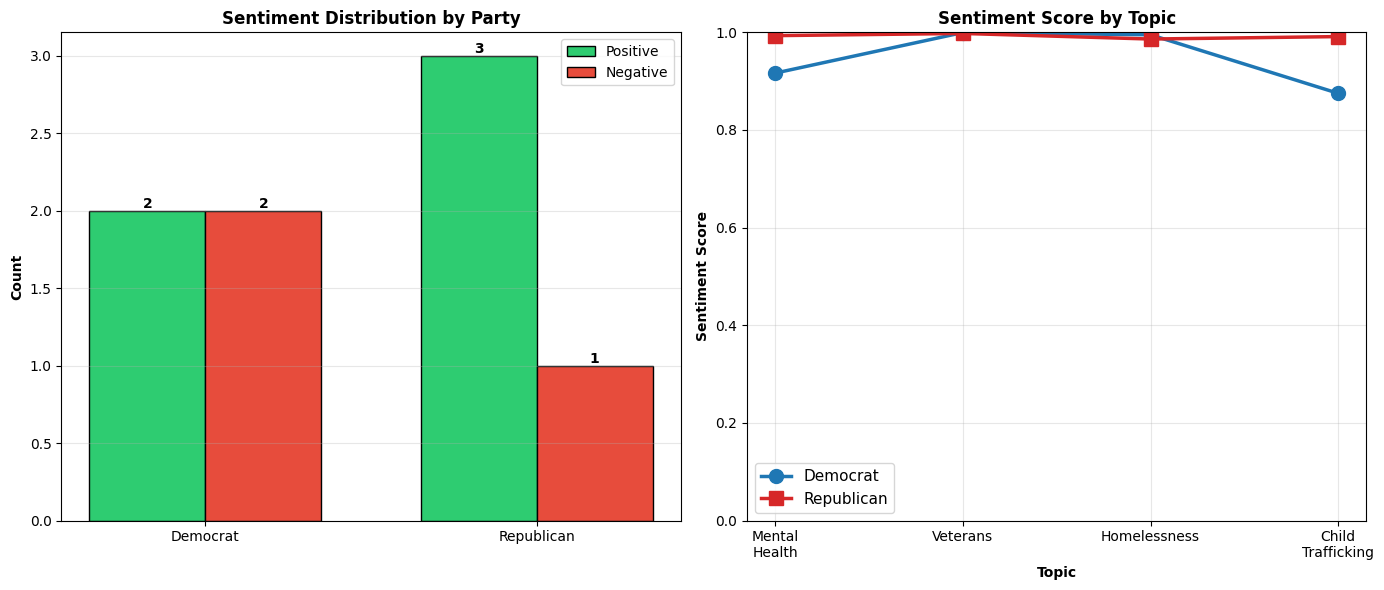

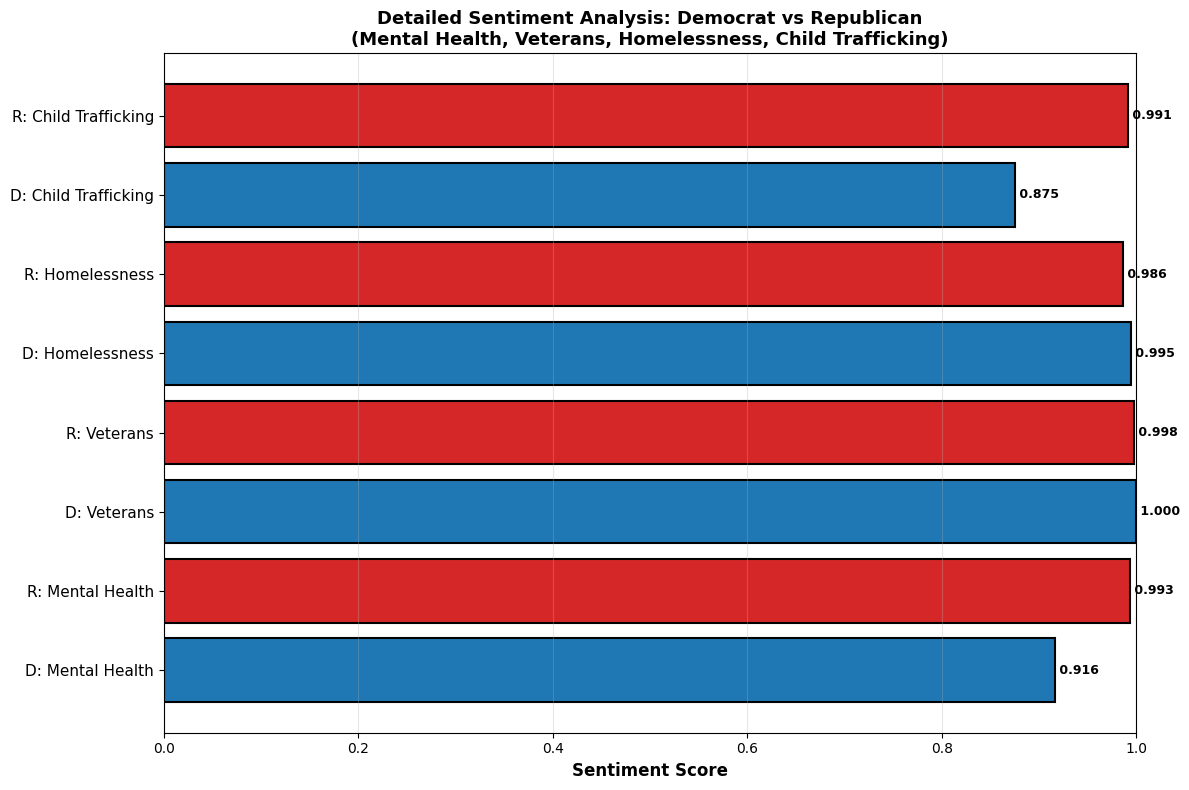


SENTIMENT ANALYSIS SUMMARY

DEMOCRAT SPEECHES:
  Average Sentiment Score: 0.947
  Positive Speeches: 2/4
  Negative Speeches: 2/4

REPUBLICAN SPEECHES:
  Average Sentiment Score: 0.992
  Positive Speeches: 3/4
  Negative Speeches: 1/4

DIFFERENCE:
  Republican speeches are more positive
  Difference: 0.046

BY TOPIC:
  Mental Health        → Republican is more positive (0.077 difference)
  Veterans             → Democrat is more positive (0.002 difference)
  Homelessness         → Democrat is more positive (0.009 difference)
  Child Trafficking    → Republican is more positive (0.116 difference)


In [ ]:
from transformers import pipeline
import matplotlib.pyplot as plt
import numpy as np

# Load sentiment analysis model
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

def analyze_sentiment(text):
    """Analyze sentiment of text."""
    # Truncate if too long (BERT has 512 token limit)
    words = text.split()
    if len(words) > 500:
        text = " ".join(words[:500])

    result = sentiment_analyzer(text)
    return result[0]['label'], result[0]['score']

def generate_and_analyze_speeches():
    """Generate speeches and analyze sentiment by party."""

    results = {
        'Democrat': {'sentiments': [], 'scores': [], 'texts': []},
        'Republican': {'sentiments': [], 'scores': [], 'texts': []}
    }

    topics = [
        "mental health and mental health services",
        "veterans and veteran support",
        "homelessness and housing crisis",
        "child trafficking and exploitation"
    ]

    # Generate Democrat speeches
    print("="*70)
    print("GENERATING DEMOCRAT SPEECHES")
    print("="*70)
    for topic in topics:
        speech = generate_congressional_speech_finetuned("Democrat", "House", topic)
        sentiment, score = analyze_sentiment(speech)
        results['Democrat']['sentiments'].append(sentiment)
        results['Democrat']['scores'].append(score)
        results['Democrat']['texts'].append(speech)
        print(f"\n✓ Topic: {topic}")
        print(f"  Sentiment: {sentiment} ({score:.3f})")

    # Generate Republican speeches
    print("\n" + "="*70)
    print("GENERATING REPUBLICAN SPEECHES")
    print("="*70)
    for topic in topics:
        speech = generate_congressional_speech_finetuned("Republican", "House", topic)
        sentiment, score = analyze_sentiment(speech)
        results['Republican']['sentiments'].append(sentiment)
        results['Republican']['scores'].append(score)
        results['Republican']['texts'].append(speech)
        print(f"\n✓ Topic: {topic}")
        print(f"  Sentiment: {sentiment} ({score:.3f})")

    return results, topics

# Generate and analyze
results, topics = generate_and_analyze_speeches()

# VISUALIZATION 1: Sentiment Distribution by Party
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

dem_positive = sum(1 for s in results['Democrat']['sentiments'] if s == 'POSITIVE')
dem_negative = sum(1 for s in results['Democrat']['sentiments'] if s == 'NEGATIVE')

rep_positive = sum(1 for s in results['Republican']['sentiments'] if s == 'POSITIVE')
rep_negative = sum(1 for s in results['Republican']['sentiments'] if s == 'NEGATIVE')

# Bar chart: Sentiment counts
ax = axes[0]
parties = ['Democrat', 'Republican']
positive_counts = [dem_positive, rep_positive]
negative_counts = [dem_negative, rep_negative]

x = np.arange(len(parties))
width = 0.35

bars1 = ax.bar(x - width/2, positive_counts, width, label='Positive', color='#2ecc71', edgecolor='black')
bars2 = ax.bar(x + width/2, negative_counts, width, label='Negative', color='#e74c3c', edgecolor='black')

ax.set_ylabel('Count', fontweight='bold')
ax.set_title('Sentiment Distribution by Party', fontweight='bold', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(parties)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# Line chart: Sentiment scores by topic
ax = axes[1]
dem_scores = results['Democrat']['scores']
rep_scores = results['Republican']['scores']

x_pos = np.arange(len(topics))
ax.plot(x_pos, dem_scores, marker='o', linewidth=2.5, markersize=10, label='Democrat', color='#1f77b4')
ax.plot(x_pos, rep_scores, marker='s', linewidth=2.5, markersize=10, label='Republican', color='#d62728')

ax.set_ylabel('Sentiment Score', fontweight='bold')
ax.set_xlabel('Topic', fontweight='bold')
ax.set_title('Sentiment Score by Topic', fontweight='bold', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(['Mental\nHealth', 'Veterans', 'Homelessness', 'Child\nTrafficking'], fontsize=10)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# VISUALIZATION 2: Detailed sentiment scores
fig, ax = plt.subplots(figsize=(12, 8))

all_data = []
all_labels = []
all_colors = []

topic_labels = ['Mental Health', 'Veterans', 'Homelessness', 'Child Trafficking']

for i, topic_label in enumerate(topic_labels):
    all_data.append(results['Democrat']['scores'][i])
    all_labels.append(f"D: {topic_label}")
    all_colors.append('#1f77b4')

    all_data.append(results['Republican']['scores'][i])
    all_labels.append(f"R: {topic_label}")
    all_colors.append('#d62728')

bars = ax.barh(range(len(all_data)), all_data, color=all_colors, edgecolor='black', linewidth=1.5)

ax.set_yticks(range(len(all_labels)))
ax.set_yticklabels(all_labels, fontsize=11)
ax.set_xlabel('Sentiment Score', fontweight='bold', fontsize=12)
ax.set_title('Detailed Sentiment Analysis: Democrat vs Republican\n(Mental Health, Veterans, Homelessness, Child Trafficking)',
             fontweight='bold', fontsize=13)
ax.set_xlim(0, 1)
ax.grid(axis='x', alpha=0.3)

# Add value labels
for bar, score in zip(bars, all_data):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2,
           f' {score:.3f}', ha='left', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# SUMMARY STATISTICS
print("\n" + "="*70)
print("SENTIMENT ANALYSIS SUMMARY")
print("="*70)

dem_avg_score = np.mean(results['Democrat']['scores'])
rep_avg_score = np.mean(results['Republican']['scores'])

print(f"\nDEMOCRAT SPEECHES:")
print(f"  Average Sentiment Score: {dem_avg_score:.3f}")
print(f"  Positive Speeches: {dem_positive}/{len(results['Democrat']['sentiments'])}")
print(f"  Negative Speeches: {dem_negative}/{len(results['Democrat']['sentiments'])}")

print(f"\nREPUBLICAN SPEECHES:")
print(f"  Average Sentiment Score: {rep_avg_score:.3f}")
print(f"  Positive Speeches: {rep_positive}/{len(results['Republican']['sentiments'])}")
print(f"  Negative Speeches: {rep_negative}/{len(results['Republican']['sentiments'])}")

print(f"\nDIFFERENCE:")
more_positive = 'Democrat' if dem_avg_score > rep_avg_score else 'Republican'
print(f"  {more_positive} speeches are more positive")
print(f"  Difference: {abs(dem_avg_score - rep_avg_score):.3f}")

print(f"\nBY TOPIC:")
for i, topic_label in enumerate(topic_labels):
    dem_score = results['Democrat']['scores'][i]
    rep_score = results['Republican']['scores'][i]
    more_pos = 'Democrat' if dem_score > rep_score else 'Republican'
    print(f"  {topic_label:20s} → {more_pos} is more positive ({abs(dem_score - rep_score):.3f} difference)")

TOPIC FREQUENCY IN CONGRESSIONAL SPEECHES

Mental Health:
  Speeches mentioning topic: 14327/49956 (28.7%)
  Keywords: mental, health, depression, anxiety, psychiatric...

Veterans:
  Speeches mentioning topic: 27256/49956 (54.6%)
  Keywords: veteran, military, service, armed forces, deployment...

Homelessness:
  Speeches mentioning topic: 7957/49956 (15.9%)
  Keywords: homeless, homelessness, housing, shelter, unhoused...

Child Trafficking:
  Speeches mentioning topic: 12539/49956 (25.1%)
  Keywords: trafficking, child, exploitation, abuse, minor...

BY PARTY

DEMOCRAT (23798 speeches)
  Mental Health       : 7778 speeches ( 32.7%)
  Veterans            : 13606 speeches ( 57.2%)
  Homelessness        : 4302 speeches ( 18.1%)
  Child Trafficking   : 6614 speeches ( 27.8%)

REPUBLICAN (22674 speeches)
  Mental Health       : 5516 speeches ( 24.3%)
  Veterans            : 11780 speeches ( 52.0%)
  Homelessness        : 2996 speeches ( 13.2%)
  Child Trafficking   : 5052 speeches ( 22.3

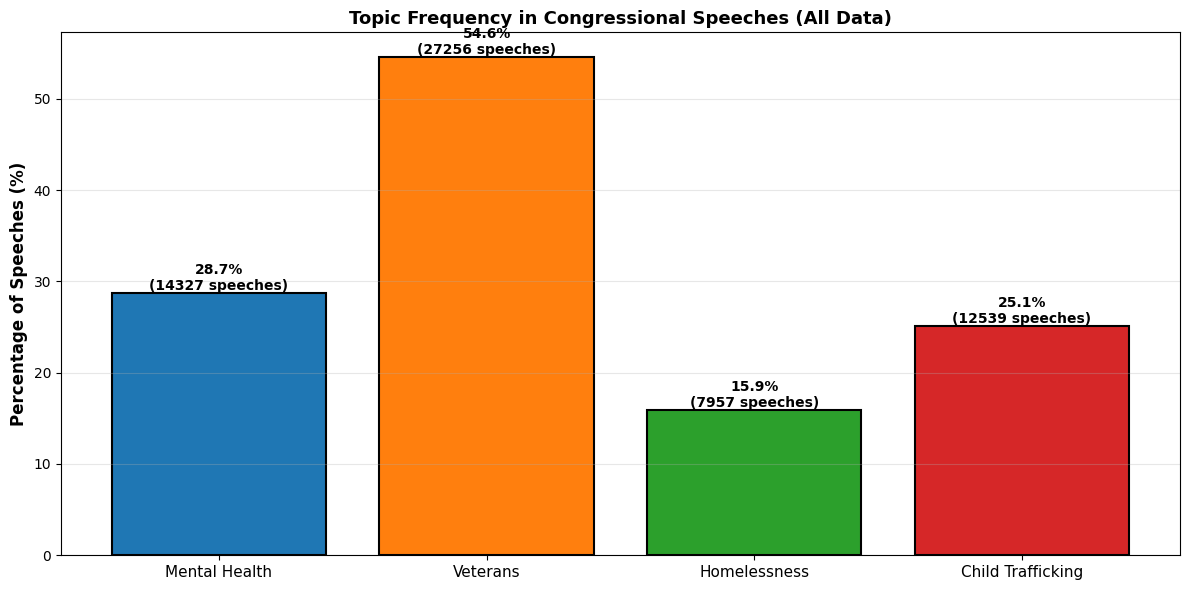

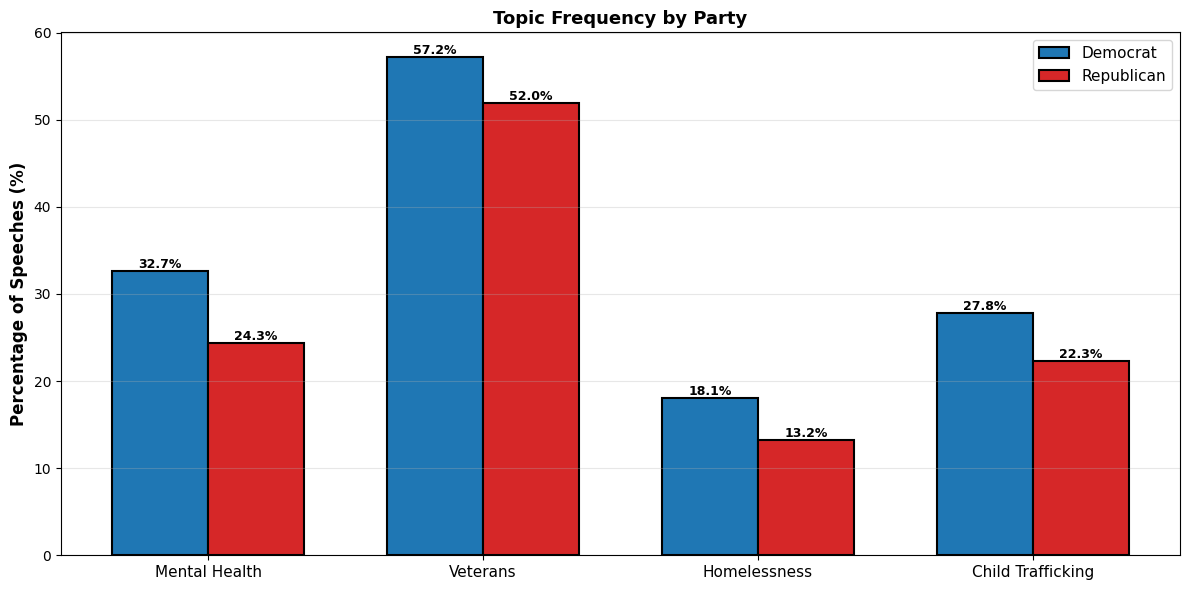

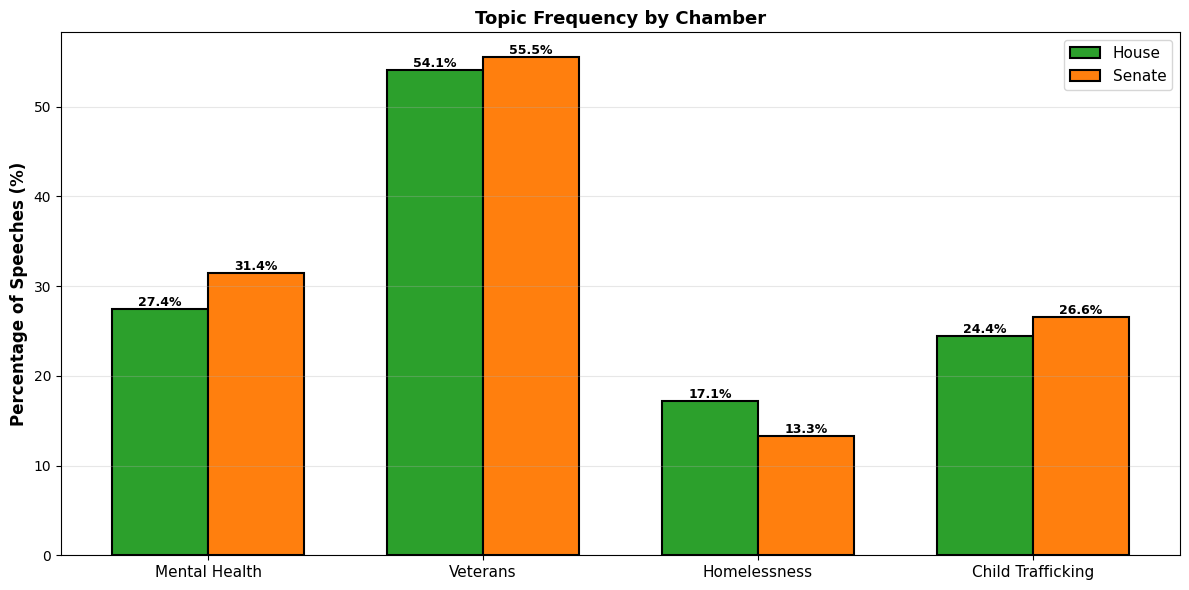


KEY INSIGHTS

Most discussed topic: Veterans (54.6%)
Least discussed topic: Homelessness (15.9%)

Party differences:
  Mental Health       : Democrats    discuss more (8.4% difference)
  Veterans            : Democrats    discuss more (5.2% difference)
  Homelessness        : Democrats    discuss more (4.9% difference)
  Child Trafficking   : Democrats    discuss more (5.5% difference)


In [ ]:
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# Define keywords for each topic
topic_keywords = {
    'Mental Health': ['mental', 'health', 'depression', 'anxiety', 'psychiatric', 'therapy', 'counseling', 'psychology', 'psychologist', 'substance', 'addiction', 'opioid'],
    'Veterans': ['veteran', 'military', 'service', 'armed forces', 'deployment', 'wounded', 'va', 'benefits', 'soldier', 'navy', 'army', 'marine'],
    'Homelessness': ['homeless', 'homelessness', 'housing', 'shelter', 'unhoused', 'street', 'housing crisis', 'affordable housing', 'eviction'],
    'Child Trafficking': ['trafficking', 'child', 'exploitation', 'abuse', 'minor', 'children', 'human trafficking', 'sex trafficking', 'kidnap']
}

def count_topic_mentions(df, keywords, column='speech_text'):
    """Count how many speeches mention each keyword set."""
    count = 0
    for text in df[column]:
        if pd.isna(text):
            continue
        text_lower = str(text).lower()
        if any(keyword.lower() in text_lower for keyword in keywords):
            count += 1
    return count

# Analyze topic frequency in original training data
print("="*70)
print("TOPIC FREQUENCY IN CONGRESSIONAL SPEECHES")
print("="*70)

# Overall statistics
results = {}
for topic, keywords in topic_keywords.items():
    count = count_topic_mentions(df_combined, keywords)
    percentage = (count / len(df_combined)) * 100
    results[topic] = {'count': count, 'percentage': percentage}
    print(f"\n{topic}:")
    print(f"  Speeches mentioning topic: {count}/{len(df_combined)} ({percentage:.1f}%)")
    print(f"  Keywords: {', '.join(keywords[:5])}...")

# By Party
print("\n" + "="*70)
print("BY PARTY")
print("="*70)

party_results = {'Democrat': {}, 'Republican': {}}
for party in ['Democrat', 'Republican']:
    df_party = df_combined[df_combined['Party'] == party]
    print(f"\n{party.upper()} ({len(df_party)} speeches)")
    for topic, keywords in topic_keywords.items():
        count = count_topic_mentions(df_party, keywords)
        percentage = (count / len(df_party)) * 100 if len(df_party) > 0 else 0
        party_results[party][topic] = {'count': count, 'percentage': percentage}
        print(f"  {topic:20s}: {count:3d} speeches ({percentage:5.1f}%)")

# By Chamber
print("\n" + "="*70)
print("BY CHAMBER")
print("="*70)

chamber_results = {'House': {}, 'Senate': {}}
for chamber in ['House', 'Senate']:
    df_chamber = df_combined[df_combined['Chamber'] == chamber]
    if len(df_chamber) == 0:
        continue
    print(f"\n{chamber.upper()} ({len(df_chamber)} speeches)")
    for topic, keywords in topic_keywords.items():
        count = count_topic_mentions(df_chamber, keywords)
        percentage = (count / len(df_chamber)) * 100
        chamber_results[chamber][topic] = {'count': count, 'percentage': percentage}
        print(f"  {topic:20s}: {count:3d} speeches ({percentage:5.1f}%)")

# VISUALIZATION 1: Overall topic frequency
fig, ax = plt.subplots(figsize=(12, 6))

topics = list(results.keys())
percentages = [results[topic]['percentage'] for topic in topics]
counts = [results[topic]['count'] for topic in topics]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars = ax.bar(topics, percentages, color=colors, edgecolor='black', linewidth=1.5)

ax.set_ylabel('Percentage of Speeches (%)', fontweight='bold', fontsize=12)
ax.set_title('Topic Frequency in Congressional Speeches (All Data)', fontweight='bold', fontsize=13)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar, percentage, count in zip(bars, percentages, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{percentage:.1f}%\n({count} speeches)',
           ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.xticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.show()

# VISUALIZATION 2: By Party
fig, ax = plt.subplots(figsize=(12, 6))

topics = list(topic_keywords.keys())
dem_percentages = [party_results['Democrat'][topic]['percentage'] for topic in topics]
rep_percentages = [party_results['Republican'][topic]['percentage'] for topic in topics]

x = np.arange(len(topics))
width = 0.35

bars1 = ax.bar(x - width/2, dem_percentages, width, label='Democrat', color='#1f77b4', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, rep_percentages, width, label='Republican', color='#d62728', edgecolor='black', linewidth=1.5)

ax.set_ylabel('Percentage of Speeches (%)', fontweight='bold', fontsize=12)
ax.set_title('Topic Frequency by Party', fontweight='bold', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(topics, fontsize=11)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# VISUALIZATION 3: By Chamber
fig, ax = plt.subplots(figsize=(12, 6))

house_percentages = [chamber_results['House'][topic]['percentage'] for topic in topics]
senate_percentages = [chamber_results['Senate'][topic]['percentage'] for topic in topics]

x = np.arange(len(topics))
width = 0.35

bars1 = ax.bar(x - width/2, house_percentages, width, label='House', color='#2ca02c', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, senate_percentages, width, label='Senate', color='#ff7f0e', edgecolor='black', linewidth=1.5)

ax.set_ylabel('Percentage of Speeches (%)', fontweight='bold', fontsize=12)
ax.set_title('Topic Frequency by Chamber', fontweight='bold', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(topics, fontsize=11)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("KEY INSIGHTS")
print("="*70)

# Find most discussed topic
most_discussed = max(results, key=lambda k: results[k]['percentage'])
least_discussed = min(results, key=lambda k: results[k]['percentage'])

print(f"\nMost discussed topic: {most_discussed} ({results[most_discussed]['percentage']:.1f}%)")
print(f"Least discussed topic: {least_discussed} ({results[least_discussed]['percentage']:.1f}%)")

# Party differences
print(f"\nParty differences:")
for topic in topics:
    dem_pct = party_results['Democrat'][topic]['percentage']
    rep_pct = party_results['Republican'][topic]['percentage']
    diff = abs(dem_pct - rep_pct)
    more_discussed = 'Democrats' if dem_pct > rep_pct else 'Republicans'
    print(f"  {topic:20s}: {more_discussed:12s} discuss more ({diff:.1f}% difference)")

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


CUSTOM STOP WORDS (336 words)

EXTRACTING BIGRAMS FROM CONGRESSIONAL SPEECHES
This may take a minute...
  Processed 1000/49956 speeches...
  Processed 2000/49956 speeches...
  Processed 3000/49956 speeches...
  Processed 4000/49956 speeches...
  Processed 5000/49956 speeches...
  Processed 6000/49956 speeches...
  Processed 7000/49956 speeches...
  Processed 8000/49956 speeches...
  Processed 9000/49956 speeches...
  Processed 10000/49956 speeches...
  Processed 11000/49956 speeches...
  Processed 12000/49956 speeches...
  Processed 13000/49956 speeches...
  Processed 14000/49956 speeches...
  Processed 15000/49956 speeches...
  Processed 16000/49956 speeches...
  Processed 17000/49956 speeches...
  Processed 18000/49956 speeches...
  Processed 19000/49956 speeches...
  Processed 20000/49956 speeches...
  Processed 21000/49956 speeches...
  Processed 22000/49956 speeches...
  Processed 23000/49956 speeches...
  Processed 24000/49956 speeches...
  Processed 25000/49956 speeches...
  Pro

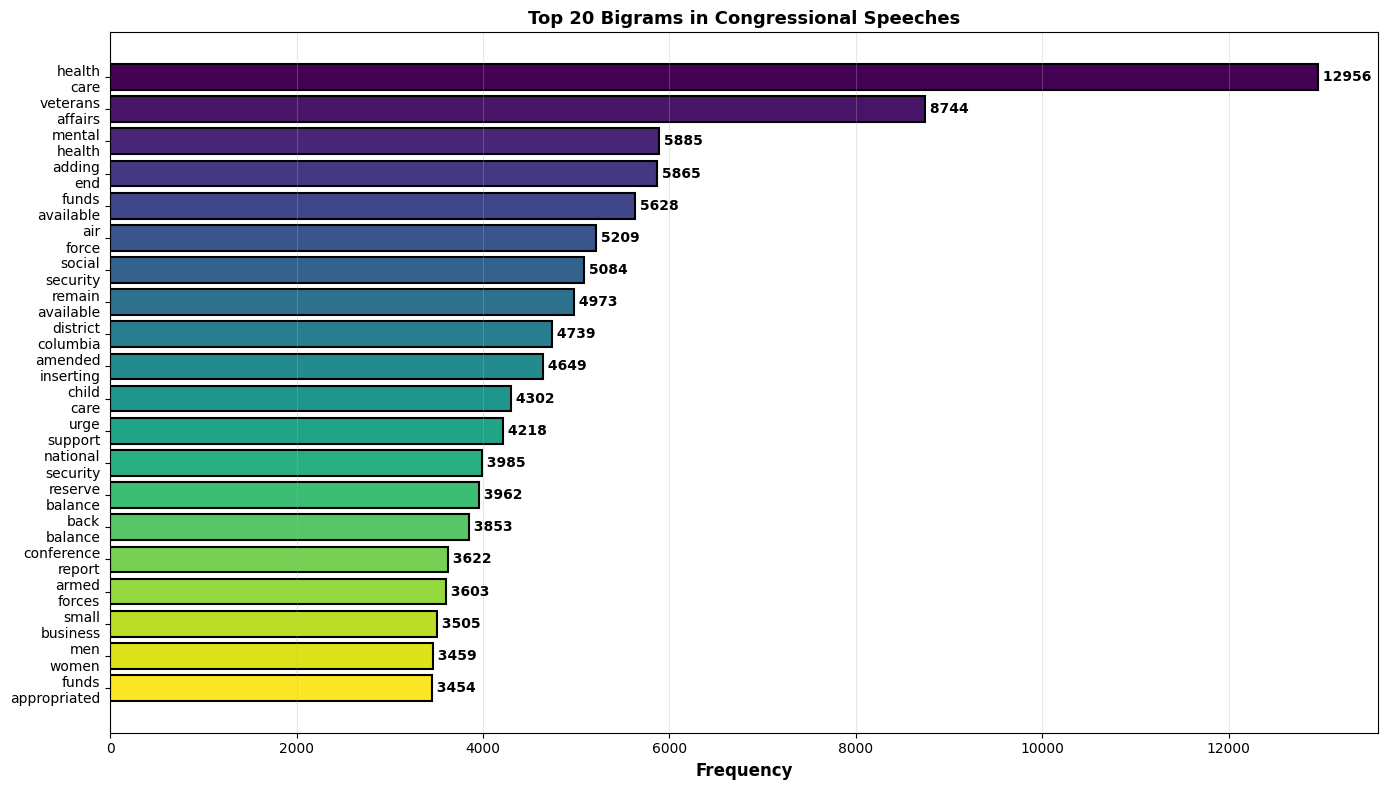

✓ Saved: top_bigrams_vertical.png


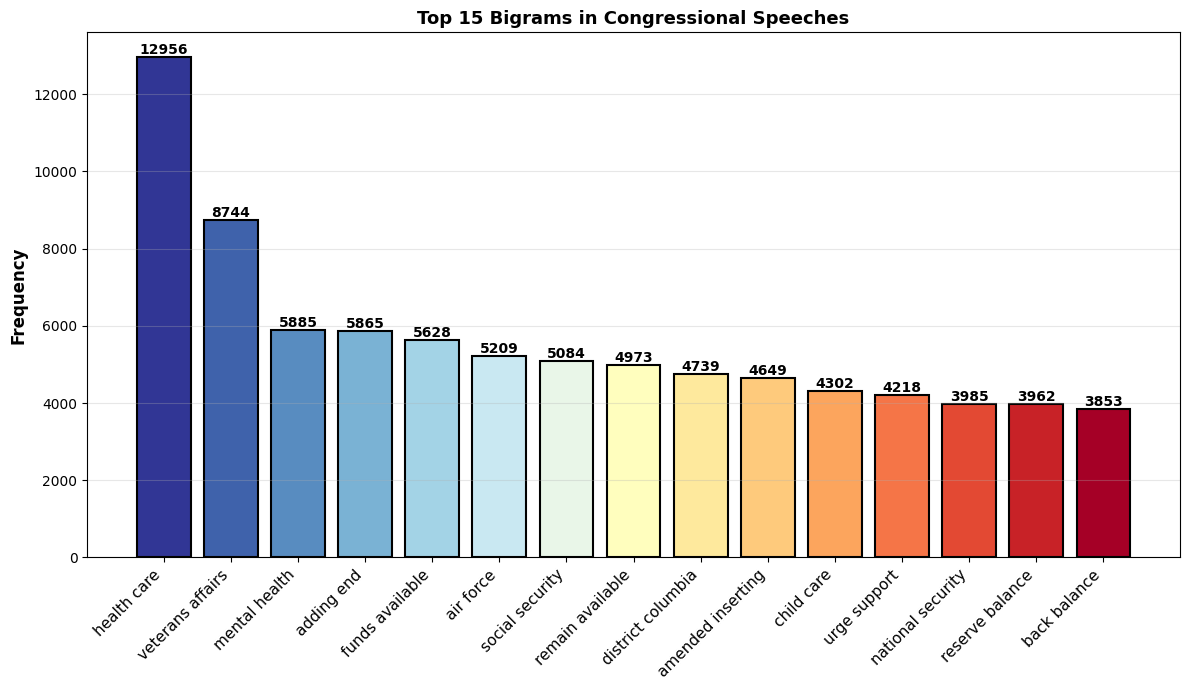


TOP BIGRAMS BY PARTY

DEMOCRAT:
   1. health          care            -  6644 times
   2. mental          health          -  3424 times
   3. veterans        affairs         -  3296 times
   4. remain          available       -  2840 times
   5. social          security        -  2796 times
   6. funds           available       -  2512 times
   7. child           care            -  2422 times
   8. urge            support         -  2050 times
   9. adding          end             -  2020 times
  10. domestic        violence        -  2016 times

REPUBLICAN:
   1. health          care            -  5450 times
   2. veterans        affairs         -  4690 times
   3. adding          end             -  3168 times
   4. air             force           -  2798 times
   5. district        columbia        -  2574 times
   6. funds           available       -  2542 times
   7. amended         inserting       -  2402 times
   8. reserve         balance         -  2012 times
   9. national    

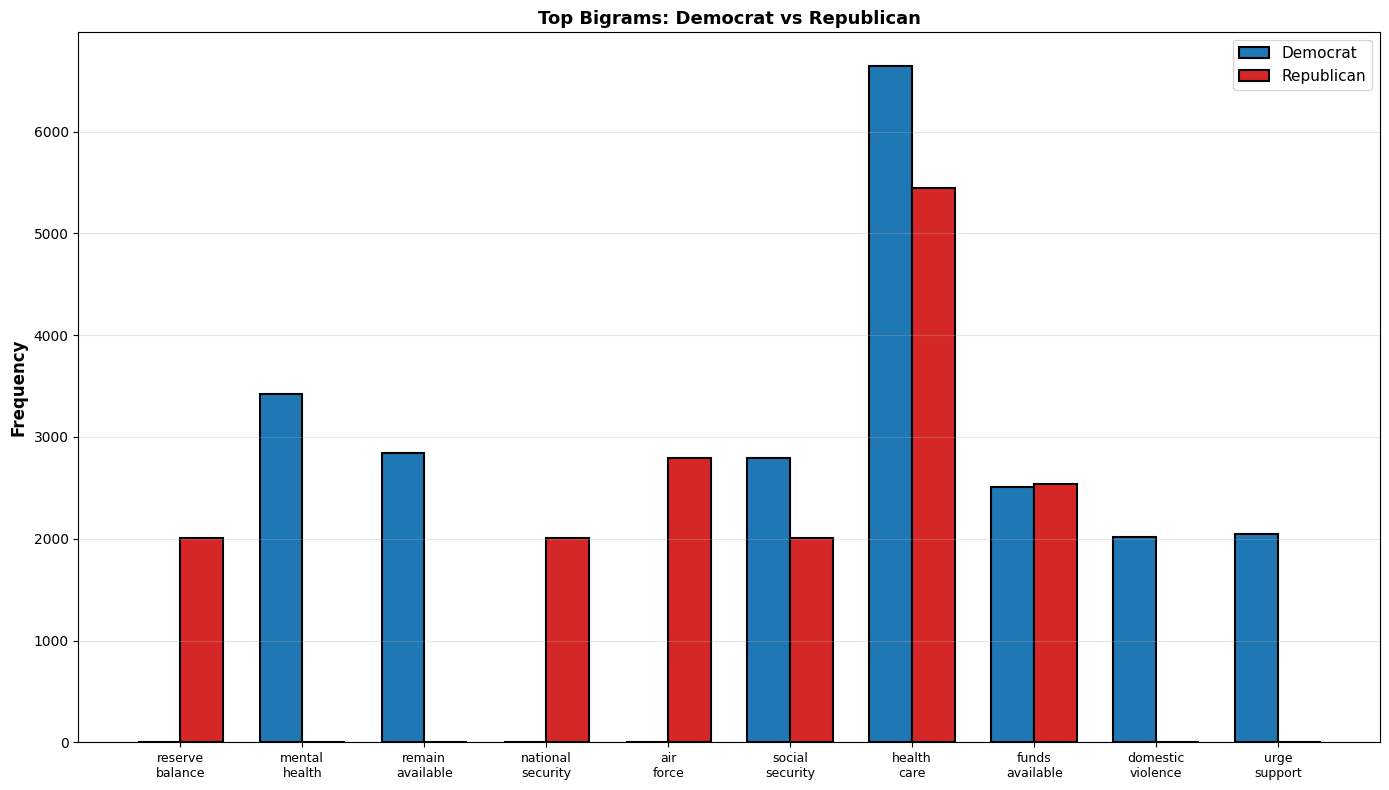


ANALYSIS COMPLETE!


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Get English stop words
stop_words = set(stopwords.words('english'))

# ===== YOUR CUSTOM STOP WORDS =====
custom_stop_words = {
    "agency", "the", "a", "an", "and", "or", "if", "of", "for", "in", "on", "at", "by", "to", "from", "with",
    "people", "state", "want", "going", "is", "are", "was", "were", "be", "been", "being", "as", "it", "its",
    "this", "that", "these", "those", "i", "me", "my", "we", "our", "you", "your", "he", "she", "they", "them",
    "their", "his", "her", "not", "but", "do", "does", "did", "so", "because", "can", "could", "should", "would",
    "will", "may", "might", "also", "just", "very", "much", "more", "such", "than", "then", "there", "here",
    "when", "where", "who", "what", "which", "how", "all", "any", "each", "every", "some", "no", "nor", "only",
    "own", "same", "too", "into", "up", "down", "about", "over", "under", "thank", "thankyou", "yield", "gentleman",
    "gentlewoman", "chair", "chairman", "chairwoman", "speaker", "presiding", "recognize", "recognized", "recognition",
    "remarks", "floor", "colleague", "colleagues", "proceed", "order", "ordered", "committee", "subcommittee", "motion",
    "unanimous", "consent", "debate", "amendment", "amend", "section", "title", "chapter", "paragraph", "subparagraph",
    "clause", "statutory", "herein", "whereas", "therefore", "resolved", "pursuant", "enact", "enacted", "mr", "mrs",
    "ms", "madam", "sir", "act", "bill", "resolution", "senate", "house", "representative", "representatives", "congress",
    "member", "members", "session", "hearing", "witness", "testimony", "law", "legislation", "legislative", "vote",
    "enactment", "proceedings", "statute", "appropriation", "federal", "agency", "program", "department", "secretary",
    "policy", "administration", "executive", "authority", "director", "office", "ranking", "majority", "minority", "sec",
    "subsec", "subtitle", "appendix", "figure", "table", "page", "pages", "line", "lines", "insert", "strike", "sentence",
    "word", "words", "heading", "part", "division", "codified", "usc", "code", "public", "law", "number", "numbers",
    "date", "dates", "document", "doc", "clerk", "shall", "must", "make", "made", "makes", "take", "taken", "took", "get",
    "got", "getting", "give", "gave", "let", "say", "said", "says", "see", "seen", "look", "looked", "know", "known",
    "think", "thought", "myself", "ours", "ourselves", "your", "yours", "yourself", "yourselves", "him", "his", "himself",
    "hers", "herself", "theirs", "themselves", "itself", "one", "ones", "someone", "anyone", "everyone", "noone", "many",
    "none", "both", "either", "neither", "while", "though", "although", "however", "through", "across", "around", "between",
    "within", "without", "now", "today", "time", "times", "year", "years", "day", "days", "long", "short", "new", "old",
    "first", "second", "third", "next", "last", "us", "including", "need", "percent", "miss", "dr", "chairperson",
    "president", "gentlelady", "gentlemen", "lady", "panel", "rules", "rule", "laws", "policies", "reading", "read",
    "united", "states", "america", "american", "washington", "dc", "bureau", "tomorrow", "week", "body", "move",
    "congressional", "record", "vol", "have", "has", "having", "provide", "provided", "providing", "current", "currently",
    "prior", "previous", "furthermore", "moreover", "thus", "hence", "other", "after", "before", "striking", "like",
    "following", "rise", "thank", "discuss"
}

print("="*70)
print(f"CUSTOM STOP WORDS ({len(custom_stop_words)} words)")
print("="*70)

def extract_bigrams(text, stop_words):
    """Extract bigrams from text, filtering stop words."""
    if pd.isna(text):
        return []

    # Tokenize and lowercase
    tokens = word_tokenize(str(text).lower())

    # Remove stopwords and short words
    tokens = [t for t in tokens if t.isalpha() and len(t) > 2 and t not in stop_words]

    # Create bigrams
    bigrams = [(tokens[i], tokens[i+1]) for i in range(len(tokens)-1)]
    return bigrams

print("\nEXTRACTING BIGRAMS FROM CONGRESSIONAL SPEECHES")
print("="*70)
print("This may take a minute...")

all_bigrams = []
for idx, text in enumerate(df_combined['speech_text']):
    bigrams = extract_bigrams(text, stop_words.union(custom_stop_words))
    all_bigrams.extend(bigrams)
    if (idx + 1) % 1000 == 0:
        print(f"  Processed {idx + 1}/{len(df_combined)} speeches...")

print(f"\nTotal bigrams extracted: {len(all_bigrams)}")

# Count bigrams
bigram_counter = Counter(all_bigrams)
top_bigrams = bigram_counter.most_common(30)

print("\n" + "="*70)
print("TOP 30 BIGRAMS IN CONGRESSIONAL SPEECHES")
print("="*70)

for i, (bigram, count) in enumerate(top_bigrams, 1):
    word1, word2 = bigram
    percentage = (count / len(all_bigrams)) * 100
    print(f"{i:2d}. {word1:15s} {word2:15s} - {count:5d} times ({percentage:.3f}%)")

# VISUALIZATION 1: Top 20 bigrams
fig, ax = plt.subplots(figsize=(14, 8))

top_20 = top_bigrams[:20]
bigram_labels = [f"{w1}\n{w2}" for w1, w2 in [b[0] for b in top_20]]
counts = [b[1] for b in top_20]

colors = plt.cm.viridis(np.linspace(0, 1, len(counts)))
bars = ax.barh(range(len(counts)), counts, color=colors, edgecolor='black', linewidth=1.5)

ax.set_yticks(range(len(bigram_labels)))
ax.set_yticklabels(bigram_labels, fontsize=10)
ax.set_xlabel('Frequency', fontweight='bold', fontsize=12)
ax.set_title('Top 20 Bigrams in Congressional Speeches', fontweight='bold', fontsize=13)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Add count labels
for bar, count in zip(bars, counts):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
           f' {count}', ha='left', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('top_bigrams.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: top_bigrams.png")
plt.show()

# VISUALIZATION 2: Top 15 bigrams (vertical)
fig, ax = plt.subplots(figsize=(12, 7))

top_15 = top_bigrams[:15]
bigram_labels = [f"{w1} {w2}" for w1, w2 in [b[0] for b in top_15]]
counts = [b[1] for b in top_15]

colors = plt.cm.RdYlBu_r(np.linspace(0, 1, len(counts)))
bars = ax.bar(range(len(counts)), counts, color=colors, edgecolor='black', linewidth=1.5)

ax.set_xticks(range(len(bigram_labels)))
ax.set_xticklabels(bigram_labels, rotation=45, ha='right', fontsize=11)
ax.set_ylabel('Frequency', fontweight='bold', fontsize=12)
ax.set_title('Top 15 Bigrams in Congressional Speeches', fontweight='bold', fontsize=13)
ax.grid(axis='y', alpha=0.3)

# Add count labels
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{count}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('top_bigrams_vertical.png', dpi=300, bbox_inches='tight')
print("✓ Saved: top_bigrams_vertical.png")
plt.show()

# Bigrams by party
print("\n" + "="*70)
print("TOP BIGRAMS BY PARTY")
print("="*70)

for party in ['Democrat', 'Republican']:
    df_party = df_combined[df_combined['Party'] == party]
    party_bigrams = []
    for text in df_party['speech_text']:
        bigrams = extract_bigrams(text, stop_words.union(custom_stop_words))
        party_bigrams.extend(bigrams)

    party_counter = Counter(party_bigrams)
    top_party_bigrams = party_counter.most_common(10)

    print(f"\n{party.upper()}:")
    for i, (bigram, count) in enumerate(top_party_bigrams, 1):
        word1, word2 = bigram
        print(f"  {i:2d}. {word1:15s} {word2:15s} - {count:5d} times")

# VISUALIZATION 3: Party comparison
fig, ax = plt.subplots(figsize=(14, 8))

dem_bigrams = []
rep_bigrams = []

for party, bigrams_list in [('Democrat', dem_bigrams), ('Republican', rep_bigrams)]:
    df_party = df_combined[df_combined['Party'] == party]
    for text in df_party['speech_text']:
        bigrams = extract_bigrams(text, stop_words.union(custom_stop_words))
        bigrams_list.extend(bigrams)

dem_counter = Counter(dem_bigrams)
rep_counter = Counter(rep_bigrams)

top_dem = dem_counter.most_common(10)
top_rep = rep_counter.most_common(10)

# Get unique bigrams from both
all_top = set([b[0] for b in top_dem] + [b[0] for b in top_rep])

dem_counts = [dict(top_dem).get(b, 0) for b in list(all_top)[:10]]
rep_counts = [dict(top_rep).get(b, 0) for b in list(all_top)[:10]]
labels = [f"{w1}\n{w2}" for w1, w2 in list(all_top)[:10]]

x = np.arange(len(labels))
width = 0.35

bars1 = ax.bar(x - width/2, dem_counts, width, label='Democrat', color='#1f77b4', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, rep_counts, width, label='Republican', color='#d62728', edgecolor='black', linewidth=1.5)

ax.set_ylabel('Frequency', fontweight='bold', fontsize=12)
ax.set_title('Top Bigrams: Democrat vs Republican', fontweight='bold', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=9)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('bigrams_by_party.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: bigrams_by_party.png")
plt.show()

print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)


Mental Health: 14327 speeches (28.7%)
Veterans: 27256 speeches (54.6%)
Child Trafficking: 12539 speeches (25.1%)
✓ Saved: topic_frequency_overall.png


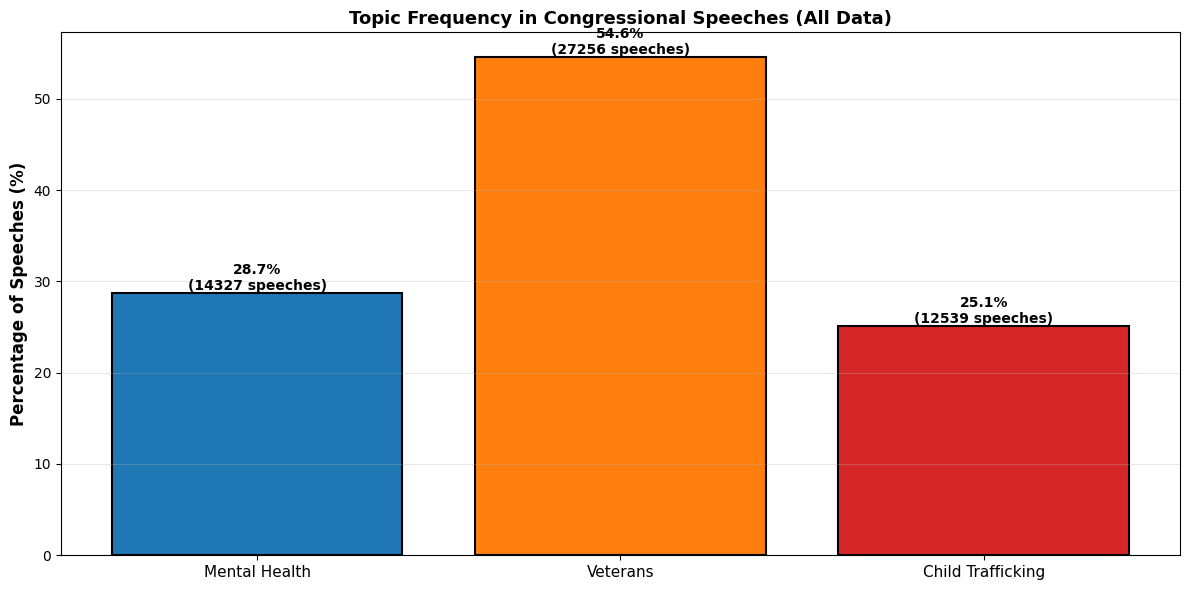

✓ Saved: topic_frequency_by_party.png


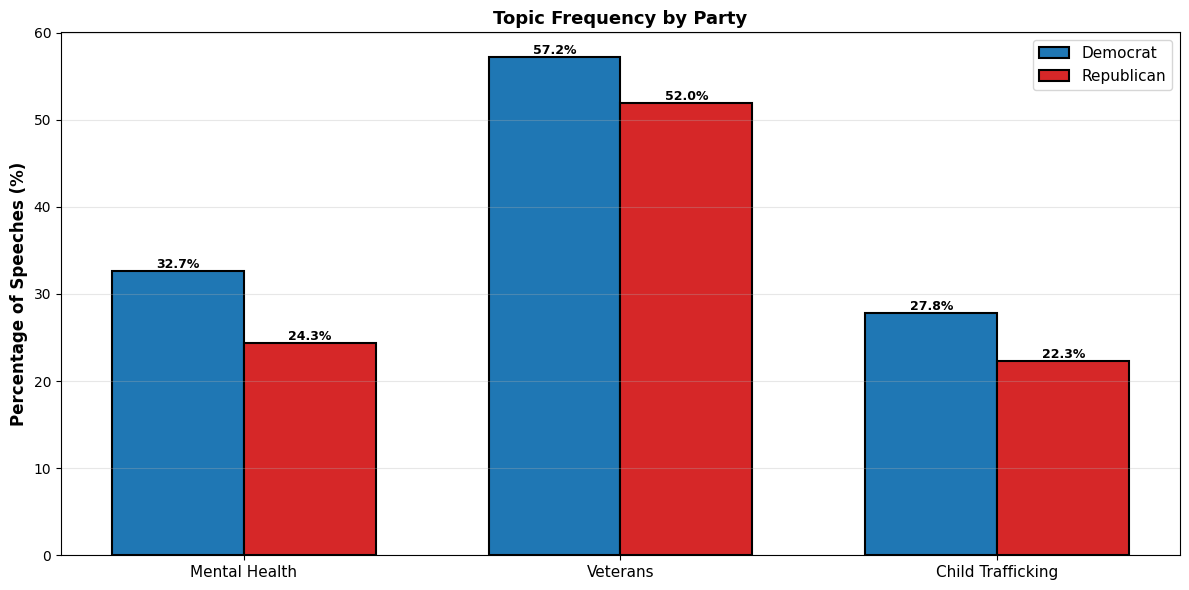

✓ Saved: topic_frequency_by_chamber.png


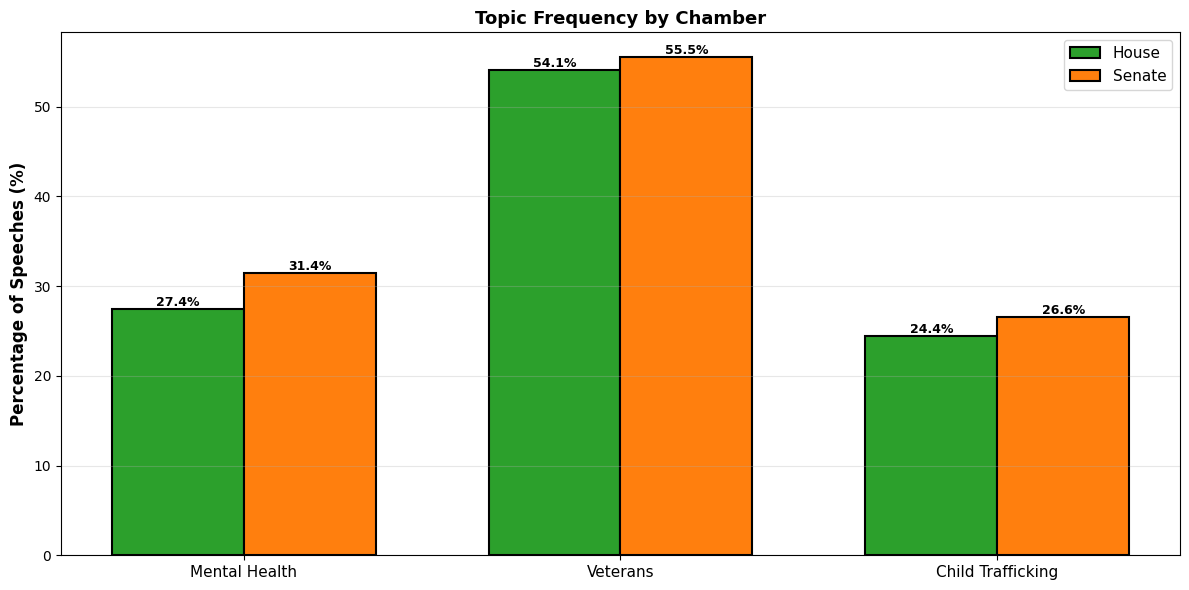


All graphs saved!


In [ ]:
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# Define keywords for each topic (REMOVED HOMELESSNESS)
topic_keywords = {
    'Mental Health': ['mental', 'health', 'depression', 'anxiety', 'psychiatric', 'therapy', 'counseling', 'psychology', 'psychologist', 'substance', 'addiction', 'opioid'],
    'Veterans': ['veteran', 'military', 'service', 'armed forces', 'deployment', 'wounded', 'va', 'benefits', 'soldier', 'navy', 'army', 'marine'],
    'Child Trafficking': ['trafficking', 'child', 'exploitation', 'abuse', 'minor', 'children', 'human trafficking', 'sex trafficking', 'kidnap']
}

def count_topic_mentions(df, keywords, column='speech_text'):
    """Count how many speeches mention each keyword set."""
    count = 0
    for text in df[column]:
        if pd.isna(text):
            continue
        text_lower = str(text).lower()
        if any(keyword.lower() in text_lower for keyword in keywords):
            count += 1
    return count

# Analyze topic frequency
results = {}
for topic, keywords in topic_keywords.items():
    count = count_topic_mentions(df_combined, keywords)
    percentage = (count / len(df_combined)) * 100
    results[topic] = {'count': count, 'percentage': percentage}
    print(f"{topic}: {count} speeches ({percentage:.1f}%)")

# By Party
party_results = {'Democrat': {}, 'Republican': {}}
for party in ['Democrat', 'Republican']:
    df_party = df_combined[df_combined['Party'] == party]
    for topic, keywords in topic_keywords.items():
        count = count_topic_mentions(df_party, keywords)
        percentage = (count / len(df_party)) * 100 if len(df_party) > 0 else 0
        party_results[party][topic] = {'count': count, 'percentage': percentage}

# By Chamber
chamber_results = {'House': {}, 'Senate': {}}
for chamber in ['House', 'Senate']:
    df_chamber = df_combined[df_combined['Chamber'] == chamber]
    if len(df_chamber) > 0:
        for topic, keywords in topic_keywords.items():
            count = count_topic_mentions(df_chamber, keywords)
            percentage = (count / len(df_chamber)) * 100
            chamber_results[chamber][topic] = {'count': count, 'percentage': percentage}

# ========== GRAPH 1: Overall topic frequency ==========
fig, ax = plt.subplots(figsize=(12, 6))

topics = list(results.keys())
percentages = [results[topic]['percentage'] for topic in topics]
counts = [results[topic]['count'] for topic in topics]

colors = ['#1f77b4', '#ff7f0e', '#d62728']
bars = ax.bar(topics, percentages, color=colors, edgecolor='black', linewidth=1.5)

ax.set_ylabel('Percentage of Speeches (%)', fontweight='bold', fontsize=12)
ax.set_title('Topic Frequency in Congressional Speeches (All Data)', fontweight='bold', fontsize=13)
ax.grid(axis='y', alpha=0.3)

for bar, percentage, count in zip(bars, percentages, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{percentage:.1f}%\n({count} speeches)',
           ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.xticks(rotation=0, fontsize=11)
plt.tight_layout()

# SAVE GRAPH 1
plt.savefig('topic_frequency_overall.png', dpi=300, bbox_inches='tight')
print("✓ Saved: topic_frequency_overall.png")
plt.show()

# ========== GRAPH 2: By Party ==========
fig, ax = plt.subplots(figsize=(12, 6))

topics = list(topic_keywords.keys())
dem_percentages = [party_results['Democrat'][topic]['percentage'] for topic in topics]
rep_percentages = [party_results['Republican'][topic]['percentage'] for topic in topics]

x = np.arange(len(topics))
width = 0.35

bars1 = ax.bar(x - width/2, dem_percentages, width, label='Democrat', color='#1f77b4', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, rep_percentages, width, label='Republican', color='#d62728', edgecolor='black', linewidth=1.5)

ax.set_ylabel('Percentage of Speeches (%)', fontweight='bold', fontsize=12)
ax.set_title('Topic Frequency by Party', fontweight='bold', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(topics, fontsize=11)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()

# SAVE GRAPH 2
plt.savefig('topic_frequency_by_party.png', dpi=300, bbox_inches='tight')
print("✓ Saved: topic_frequency_by_party.png")
plt.show()

# ========== GRAPH 3: By Chamber ==========
fig, ax = plt.subplots(figsize=(12, 6))

house_percentages = [chamber_results['House'][topic]['percentage'] for topic in topics]
senate_percentages = [chamber_results['Senate'][topic]['percentage'] for topic in topics]

x = np.arange(len(topics))
width = 0.35

bars1 = ax.bar(x - width/2, house_percentages, width, label='House', color='#2ca02c', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, senate_percentages, width, label='Senate', color='#ff7f0e', edgecolor='black', linewidth=1.5)

ax.set_ylabel('Percentage of Speeches (%)', fontweight='bold', fontsize=12)
ax.set_title('Topic Frequency by Chamber', fontweight='bold', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(topics, fontsize=11)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()

# SAVE GRAPH 3
plt.savefig('topic_frequency_by_chamber.png', dpi=300, bbox_inches='tight')
print("✓ Saved: topic_frequency_by_chamber.png")
plt.show()

print("\n" + "="*70)
print("All graphs saved!")
print("="*70)